## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [2]:
import pandas as pd
print(pd.__version__)

2.1.4


In [3]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "/sfs/gpfs/tardis/home/rkc7gr/Desktop/MIMIC/mimic4ed-benchmark/data")

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

2025-05-05 11:29:40.502235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 11:29:40.507950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 11:29:40.512051: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 11:29:40.521627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746458980.539328  270958 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746458980.54

In [4]:
random.seed(random_seed)
np.random.seed(random_seed)

In [5]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

index  subject_id     hadm_id   stay_id               intime  \
0  215414    18566742  27103162.0  38538786  2135-07-16 16:08:00   
1  205452    16853729         NaN  30043998  2178-01-25 05:09:00   
2  200705    16026698         NaN  39475313  2128-10-19 20:01:00   
3   87038    15398519  25237915.0  35495155  2147-06-15 09:50:00   
4  373626    16787687  23674090.0  31087259  2181-03-20 10:38:00   

               outtime  anchor_age gender  anchor_year  dod  \
0  2135-07-17 01:49:00          58      F         2132  NaN   
1  2178-01-25 07:05:00          91      F         2169  NaN   
2  2128-10-19 20:16:00          23      M         2128  NaN   
3  2147-06-15 15:55:00          57      M         2136  NaN   
4  2181-03-21 12:55:00          87      F         2176  NaN   

             admittime            dischtime deathtime               ethnicity  \
0  2135-07-17 00:20:00  2135-07-18 18:20:00       NaN         HISPANIC/LATINO   
1                  NaN                  NaN       NaN                   OTHER   
2                  NaN                  NaN       NaN                     NaN   
3  2147-06-15 14:00:00  2147-06-16 16:45:00       NaN  BLACK/AFRICAN AMERICAN   
4  2181-03-20 22:01:00  2181-03-21 12:55:00       NaN  BLACK/AFRICAN AMERICAN   

             edregtime            edouttime insurance  in_year  age  \
0  2135-07-16 16:08:00  2135-07-17 01:49:00     Other     2135   61   
1                  NaN                  NaN       NaN     2178  100   
2                  NaN                  NaN       NaN     2128   23   
3  2147-06-15 09:50:00  2147-06-15 15:55:00  Medicare     2147   68   
4  2181-03-20 10:38:00  2181-03-21 12:55:00  Medicare     2181   92   

   outcome_inhospital_mortality  ed_death  before_ed_mortality  \
0                         False     False                False   
1                         False     False                False   
2                         False     False                False   
3                         False     False                False   
4                         False     False                False   

            ed_los intime_icu time_to_icu_transfer  outcome_icu_transfer_12h  \
0  0 days 09:41:00        NaN                  NaN                     False   
1  0 days 01:56:00        NaN                  NaN                     False   
2  0 days 00:15:00        NaN                  NaN                     False   
3  0 days 06:05:00        NaN                  NaN                     False   
4  1 days 02:17:00        NaN                  NaN                     False   

   outcome_hospitalization  outcome_critical  n_ed_30d  n_ed_90d  n_ed_365d  \
0                     True             False         0         0          0   
1                    False             False         0         1          7   
2                    False             False         0         0          1   
3                     True             False         0         2          5   
4                     True             False         0         0          2   

    next_ed_visit_time next_ed_visit_time_diff  outcome_ed_revisit_3d  \
0  2136-07-30 17:08:00       379 days 15:19:00                  False   
1  2178-03-11 09:43:00        45 days 02:38:00                  False   
2  2129-01-05 21:12:00        78 days 00:56:00                  False   
3  2147-07-01 10:46:00        15 days 18:51:00                  False   
4  2181-04-06 09:43:00        15 days 20:48:00                  False   

   n_hosp_30d  n_hosp_90d  n_hosp_365d  n_icu_30d  n_icu_90d  n_icu_365d  \
0           0           0            0          0          0           0   
1           0           0            5          0          0           0   
2           0           0            0          0          0           0   
3           0           2            5          0          0           1   
4           0           0            2          0          0           0   

   ed_los_hours  time_to_icu_transfer_hours  next_ed_

### 1. Task-specific filter: no task-specific exclusion needed

In [4]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 359043 , testing size = 89761


### 2. Variable Selection

In [6]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [7]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [8]:
X_train.dtypes.to_frame().T

age  gender n_ed_30d n_ed_90d n_ed_365d n_hosp_30d n_hosp_90d  \
0  int64  object    int64    int64     int64      int64      int64   

  n_hosp_365d n_icu_30d n_icu_90d n_icu_365d triage_temperature  \
0       int64     int64     int64      int64            float64   

  triage_heartrate triage_resprate triage_o2sat triage_sbp triage_dbp  \
0          float64         float64      float64    float64    float64   

  triage_pain triage_acuity chiefcom_chest_pain chiefcom_abdominal_pain  \
0     float64       float64                bool                    bool   

  chiefcom_headache chiefcom_shortness_of_breath chiefcom_back_pain  \
0              bool                         bool               bool   

  chiefcom_cough chiefcom_nausea_vomiting chiefcom_fever_chills  \
0           bool                     bool                  bool   

  chiefcom_syncope chiefcom_dizziness cci_MI cci_CHF cci_PVD cci_Stroke  \
0             bool               bool  int64   int64   int64      int64   

  cci_Dementia cci_Pulmonary cci_Rheumatic cci_PUD cci_Liver1 cci_DM1 cci_DM2  \
0        int64         int64         int64   int64      int64   int64   int64   

  cci_Paralysis cci_Renal cci_Cancer1 cci_Liver2 cci_Cancer2 cci_HIV  \
0         int64     int64       int64      int64       int64   int64   

  eci_Arrhythmia eci_Valvular eci_PHTN eci_HTN1 eci_HTN2 eci_NeuroOther  \
0          int64        int64    int64    int64    int64          int64   

  eci_Hypothyroid eci_Lymphoma eci_Coagulopathy eci_Obesity eci_WeightLoss  \
0           int64        int64            int64       int64          int64   

  eci_FluidsLytes eci_BloodLoss eci_Anemia eci_Alcohol eci_Drugs  \
0           int64         int64      int64       int64     int64   

  eci_Psychoses eci_Depression  
0         int64          int64

In [9]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.07053663539921165 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.9313313961029053 seconds
AUC: 0.8430266182673145
AUPRC: 0.31292278150158886
Sensitivity: 0.7742914979757085
Specificity: 0.744826023165102
Score thresold: 0.06341464848044176
2.5 97.5


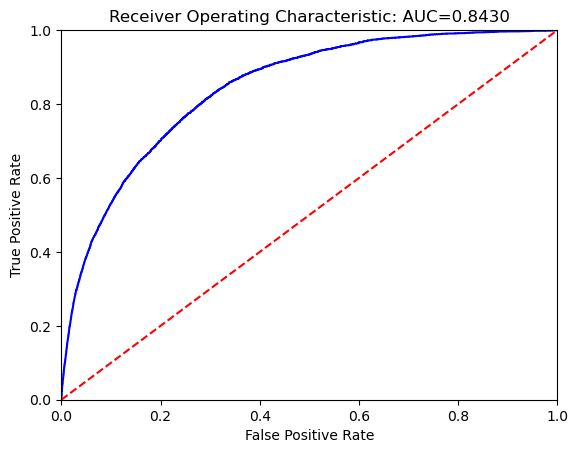

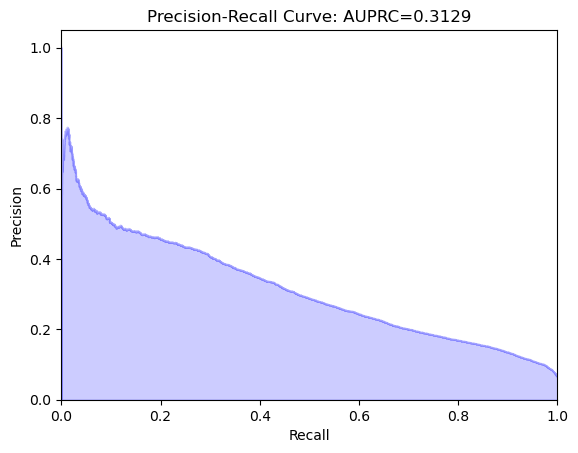

In [14]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    boot_vals = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)
    
    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sensitive_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sensitive_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        boot_vals.append(val)

    mean_val = np.mean(boot_vals)
    lower = np.percentile(boot_vals, 100 * (alpha / 2))
    upper = np.percentile(boot_vals, 100 * (1 - alpha / 2))
    
    return mean_val, (lower, upper)


In [17]:
probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)  # Threshold at 0.5

gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

print("\n=== Logistic Regression - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.935, CI = (0.933, 0.936)
Demographic Parity:    Mean = 0.006, CI = (0.005, 0.008)
Equal Opportunity:     Mean = 0.028, CI = (0.014, 0.042)
Equalized Odds:        Mean = 0.028, CI = (0.014, 0.042)


In [18]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Logistic Regression Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Logistic Regression Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.945, CI = (0.943, 0.947)
Selection Rate   Mean = 0.007, CI = (0.007, 0.008)
TPR (Recall)     Mean = 0.068, CI = (0.059, 0.077)
FPR              Mean = 0.004, CI = (0.003, 0.005)

Male:
Accuracy         Mean = 0.922, CI = (0.920, 0.925)
Selection Rate   Mean = 0.014, CI = (0.013, 0.015)
TPR (Recall)     Mean = 0.096, CI = (0.086, 0.106)
FPR              Mean = 0.007, CI = (0.006, 0.008)


In [20]:
#This model is not perfectly fair across gender.

# Accuracy: Slightly better for females. (Not a huge gap, but consistent.)

# Selection Rate: Male patients are selected twice as often (1.4% vs 0.7%).
# This violates Demographic Parity because different groups have different probabilities of positive prediction.

# True Positive Rate (Recall): Males also have better recall (detect critical outcomes better).
# Equal Opportunity would require equal TPR — but here it favors males.

# False Positive Rate (FPR):Males have a higher FPR.
# Ideally, for Equalized Odds, both TPR and FPR should match — which is not the case.

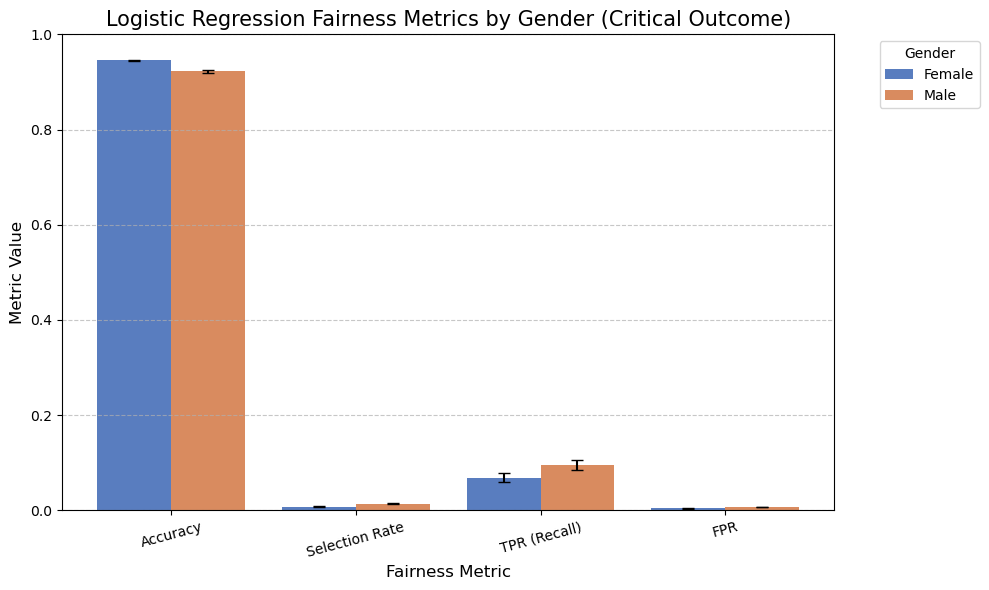

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_logreg_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_logreg_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_logreg_gender_plot = pd.DataFrame(df_logreg_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_logreg_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_logreg_gender_plot['Metric'].unique()
group_list = df_logreg_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_logreg_gender_plot[df_logreg_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Logistic Regression Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [21]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Logistic Regression - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.910, CI = (0.907, 0.912)
Demographic Parity:    Mean = 0.018, CI = (0.011, 0.032)
Equal Opportunity:     Mean = 0.128, CI = (0.062, 0.193)
Equalized Odds:        Mean = 0.128, CI = (0.062, 0.193)


In [22]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Logistic Regression - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Logistic Regression - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.897, CI = (0.893, 0.900)
Selection Rate    Mean = 0.018, CI = (0.017, 0.020)
TPR (Recall)      Mean = 0.093, CI = (0.083, 0.102)
FPR               Mean = 0.010, CI = (0.009, 0.011)

 Ethnicity: Black or African American
Accuracy          Mean = 0.937, CI = (0.933, 0.941)
Selection Rate    Mean = 0.009, CI = (0.008, 0.011)
TPR (Recall)      Mean = 0.087, CI = (0.069, 0.105)
FPR               Mean = 0.004, CI = (0.003, 0.005)

 Ethnicity: Asian
Accuracy          Mean = 0.908, CI = (0.895, 0.920)
Selection Rate    Mean = 0.021, CI = (0.015, 0.028)
TPR (Recall)      Mean = 0.149, CI = (0.099, 0.201)
FPR               Mean = 0.007, CI = (0.003, 0.011)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.946, CI = (0.940, 0.953)
Selection Rate    Mean = 0.007, CI = (0.005, 0.010)
TPR (Recall)      Mean = 0.043, CI = (0.018, 0.073)
FPR               Mean

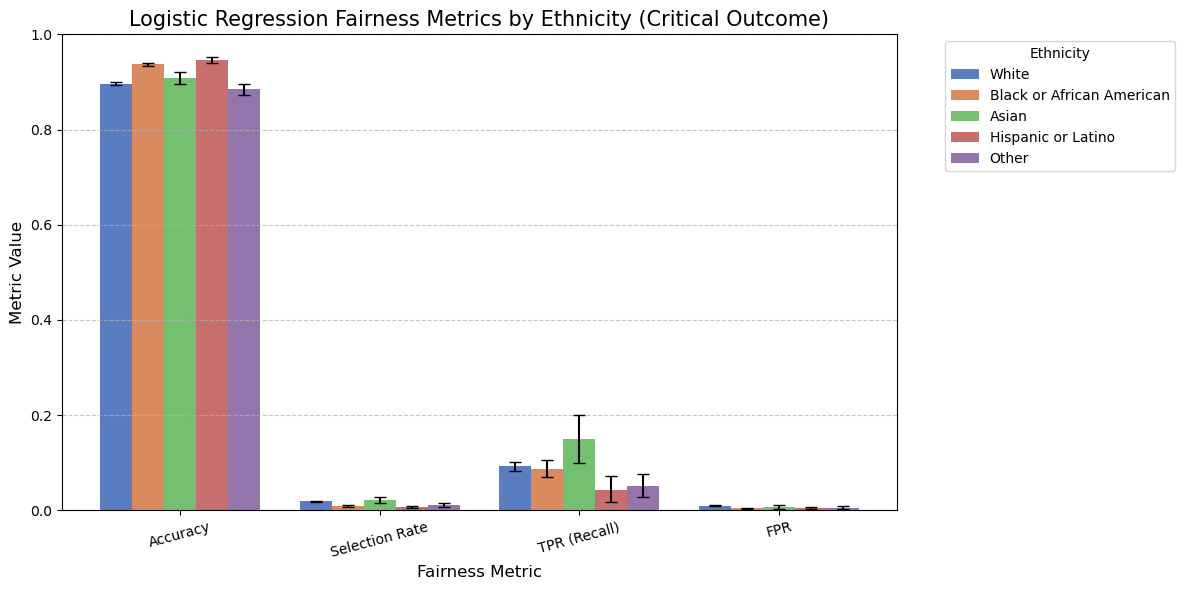

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_logreg_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_logreg_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_logreg_ethnicity_plot = pd.DataFrame(df_logreg_ethnicity_plot)


plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_logreg_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_logreg_ethnicity_plot['Metric'].unique()
group_list = df_logreg_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_logreg_ethnicity_plot[df_logreg_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Logistic Regression Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_raw = X_test['age']
valid_mask = age_raw.notna()

age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== Logistic Regression - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.935, CI = (0.933, 0.936)
Demographic Parity:    Mean = 0.086, CI = (0.051, 0.171)
Equal Opportunity:     Mean = 0.552, CI = (0.222, 1.000)
Equalized Odds:        Mean = 0.552, CI = (0.222, 1.000)


In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        metrics.append(metric)

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)


valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)

    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Logistic Regression - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Logistic Regression - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.980, CI = (0.977, 0.983)
Selection Rate    Mean = 0.000, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.011, CI = (0.000, 0.027)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.975, CI = (0.972, 0.978)
Selection Rate    Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.015, CI = (0.003, 0.028)
FPR               Mean = 0.000, CI = (0.000, 0.001)

Age Group: 35–44
Accuracy          Mean = 0.964, CI = (0.960, 0.967)
Selection Rate    Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.013, CI = (0.003, 0.025)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 45–54
Accuracy          Mean = 0.949, CI = (0.9

In [30]:
# Accuracy Trends
# Accuracy decreases with age.

# Younger groups (18–44) have extremely high accuracy (96%–98%).
# Older groups (65+) see a noticeable drop (down to ~87.5% for 75+).

# Selection Rate Trends
# Younger patients (18–44) are almost never selected (predicted as critical outcome).
# Older patients (65+) are selected much more often.

# True Positive Rate (TPR / Recall) Trends
# Very low recall for young patients: 18–24: 1.1% recall → almost none of the truly critical younger patients are detected.

# Recall steadily increases with age: 75+: 12.7% recall → better, but still not very high.

# False Positive Rate (FPR) Trends
# Across all groups, FPR is low. But FPR is slightly higher in older patients:

# 75+: 1.8% FPR compared to almost 0% for 18–44.

# model is age-biased:
# ➔ Underperforms for young patients, likely over-relies on age to flag critical risk.

# Model prioritizes older patients, but it might miss critically ill young people.

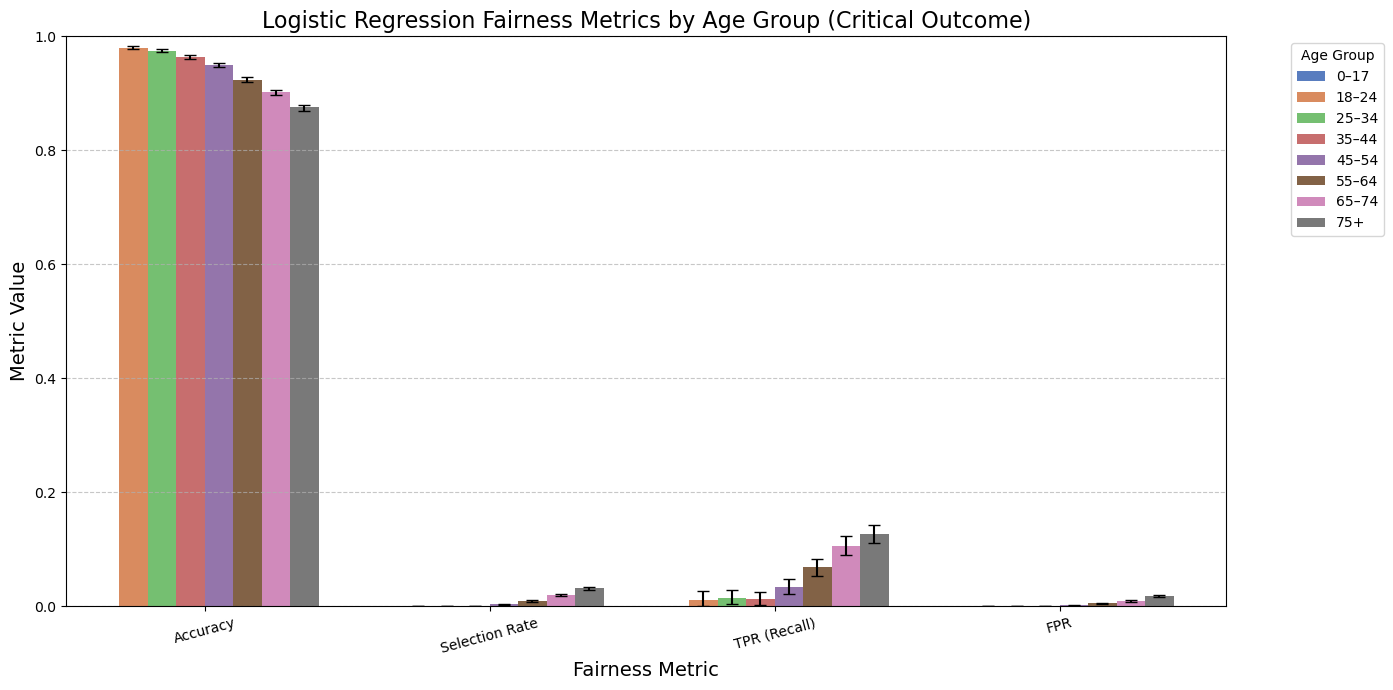

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_logreg_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_logreg_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_logreg_age_plot = pd.DataFrame(df_logreg_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_logreg_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_logreg_age_plot['Metric'].unique()
group_list = df_logreg_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_logreg_age_plot[df_logreg_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Logistic Regression Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)


insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)

print("\n=== Logistic Regression - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Logistic Regression - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===
Accuracy:              Mean = 0.864, CI = (0.861, 0.868)
Demographic Parity:    Mean = 0.023, CI = (0.019, 0.027)
Equal Opportunity:     Mean = 0.060, CI = (0.042, 0.082)
Equalized Odds:        Mean = 0.060, CI = (0.042, 0.082)


In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

probs = logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))

    return values[0], mean, (ci_lower, ci_upper)  # Return original sample, mean, CI

group_metrics = []
group_names = insurance_grouped.unique()

for group in group_names:
    mask = (insurance_grouped == group).values

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)

    group_metrics.append({
        'Insurance': group,
        'SR_Orig': sr_orig, 'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Orig': tpr_orig, 'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Orig': fpr_orig, 'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Orig': acc_orig, 'ACC_Mean': acc_mean, 'ACC_CI': acc_ci,
    })

df_insurance_metrics = pd.DataFrame(group_metrics)

print("\n=== Logistic Regression - Fairness Metrics by Insurance Group for Critical Outcome ===")

print("\n=== Accuracy by Insurance Group ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['ACC_CI']
    print(f"{row['Insurance']}: Mean = {row['ACC_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Demographic Parity (Selection Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['SR_CI']
    print(f"{row['Insurance']}: Mean = {row['SR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equal Opportunity (True Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['TPR_CI']
    print(f"{row['Insurance']}: Mean = {row['TPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equalized Odds (False Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['FPR_CI']
    print(f"{row['Insurance']}: Mean = {row['FPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")





=== Logistic Regression - Fairness Metrics by Insurance Group for Critical Outcome ===

=== Accuracy by Insurance Group ===
Medicaid: Mean = 0.883, CI = (0.873, 0.893)
Medicare: Mean = 0.842, CI = (0.837, 0.848)
Other: Mean = 0.878, CI = (0.873, 0.882)

=== Demographic Parity (Selection Rate) ===
Medicaid: Mean = 0.010, CI = (0.007, 0.013)
Medicare: Mean = 0.032, CI = (0.030, 0.035)
Other: Mean = 0.013, CI = (0.012, 0.014)

=== Equal Opportunity (True Positive Rate) ===
Medicaid: Mean = 0.054, CI = (0.033, 0.075)
Medicare: Mean = 0.112, CI = (0.099, 0.124)
Other: Mean = 0.060, CI = (0.051, 0.068)

=== Equalized Odds (False Positive Rate) ===
Medicaid: Mean = 0.004, CI = (0.002, 0.006)
Medicare: Mean = 0.017, CI = (0.015, 0.019)
Other: Mean = 0.006, CI = (0.005, 0.008)


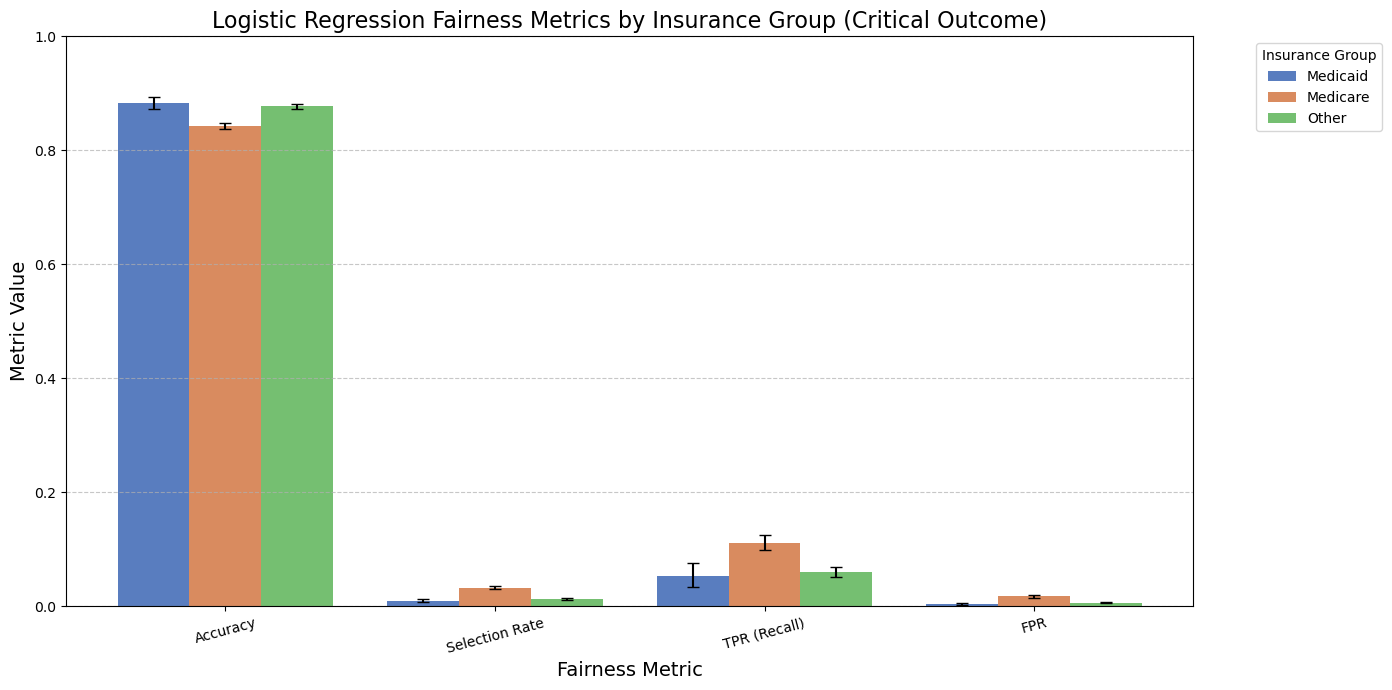

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_logreg_insurance_plot = pd.DataFrame({
    'Group': list(df_insurance_metrics['Insurance']) * 4,
    'Metric': ['Accuracy'] * len(df_insurance_metrics) +
              ['Selection Rate'] * len(df_insurance_metrics) +
              ['TPR (Recall)'] * len(df_insurance_metrics) +
              ['FPR'] * len(df_insurance_metrics),
    'Mean': list(df_insurance_metrics['ACC_Mean']) +
            list(df_insurance_metrics['SR_Mean']) +
            list(df_insurance_metrics['TPR_Mean']) +
            list(df_insurance_metrics['FPR_Mean']),
    'Lower': [ci[0] for ci in df_insurance_metrics['ACC_CI']] +
             [ci[0] for ci in df_insurance_metrics['SR_CI']] +
             [ci[0] for ci in df_insurance_metrics['TPR_CI']] +
             [ci[0] for ci in df_insurance_metrics['FPR_CI']],
    'Upper': [ci[1] for ci in df_insurance_metrics['ACC_CI']] +
             [ci[1] for ci in df_insurance_metrics['SR_CI']] +
             [ci[1] for ci in df_insurance_metrics['TPR_CI']] +
             [ci[1] for ci in df_insurance_metrics['FPR_CI']]
})

df_logreg_insurance_plot['Error Lower'] = df_logreg_insurance_plot['Mean'] - df_logreg_insurance_plot['Lower']
df_logreg_insurance_plot['Error Upper'] = df_logreg_insurance_plot['Upper'] - df_logreg_insurance_plot['Mean']

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_logreg_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2,
    order=['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR'] 
)

metric_list = ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']
group_list = df_logreg_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups  # Adjust group width for spacing

for i, metric in enumerate(metric_list):
    subset = df_logreg_insurance_plot[df_logreg_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Logistic Regression Fairness Metrics by Insurance Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


RandomForest:
Training time: 64.9912223815918 seconds
AUC: 0.8867242560167937
AUPRC: 0.42222672321423527
Sensitivity: 0.8087044534412956
Specificity: 0.8074147412116947
Score thresold: 0.08262857142857144
2.5 97.5


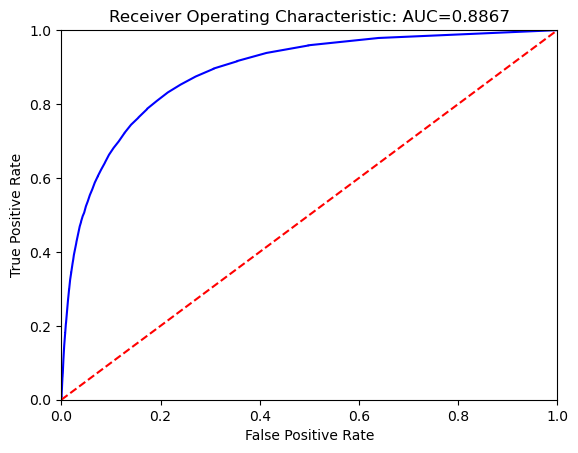

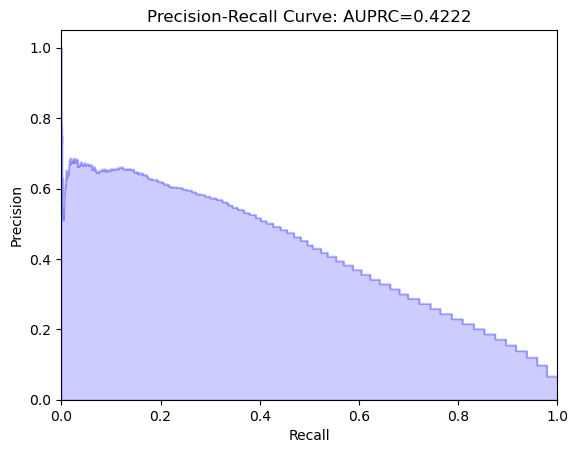

[0.10101225 0.01419198 0.00639441 0.01017503 0.01895481 0.00614948
 0.01008811 0.01668604 0.00315344 0.00631422 0.0116607  0.0746904
 0.09717177 0.05511334 0.06551145 0.09596234 0.08584786 0.04648671
 0.07822539 0.00567364 0.00607159 0.00370792 0.00144241 0.00209157
 0.00227495 0.00271101 0.00451015 0.0031848  0.00287667 0.00508922
 0.00562095 0.00496889 0.00509561 0.00275414 0.00713083 0.00266838
 0.00271532 0.00470177 0.00728061 0.00463391 0.00236358 0.00500886
 0.00531326 0.00278362 0.00382836 0.00105201 0.00684685 0.00460921
 0.00437643 0.00484517 0.00854827 0.00582892 0.00553152 0.0016552
 0.00526457 0.00540706 0.00440203 0.0069009  0.00214043 0.00445456
 0.00481082 0.00373278 0.00244775 0.00685376]


In [11]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [19]:
probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

In [20]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    values = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)

    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sf_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sf_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))

    return mean_val, (ci_lower, ci_upper)


In [21]:
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

metrics_summary = {
    "Accuracy": (acc_mean, acc_ci),
    "Demographic Parity": (dpd_mean, dpd_ci),
    "Equal Opportunity": (eopp_mean, eopp_ci),
    "Equalized Odds": (eod_mean, eod_ci)
}

print("\n=== Random Forest - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
for name, (mean, (ci_low, ci_high)) in metrics_summary.items():
    print(f"{name:<22} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy               Mean = 0.939, CI = (0.937, 0.941)
Demographic Parity     Mean = 0.008, CI = (0.006, 0.010)
Equal Opportunity      Mean = 0.014, CI = (0.001, 0.033)
Equalized Odds         Mean = 0.014, CI = (0.003, 0.033)


In [22]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Random Forest Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.950, CI = (0.948, 0.952)
Selection Rate   Mean = 0.020, CI = (0.019, 0.022)
TPR (Recall)     Mean = 0.228, CI = (0.211, 0.245)
FPR              Mean = 0.008, CI = (0.008, 0.009)

Male:
Accuracy         Mean = 0.927, CI = (0.924, 0.929)
Selection Rate   Mean = 0.029, CI = (0.027, 0.030)
TPR (Recall)     Mean = 0.216, CI = (0.202, 0.230)
FPR              Mean = 0.012, CI = (0.011, 0.014)


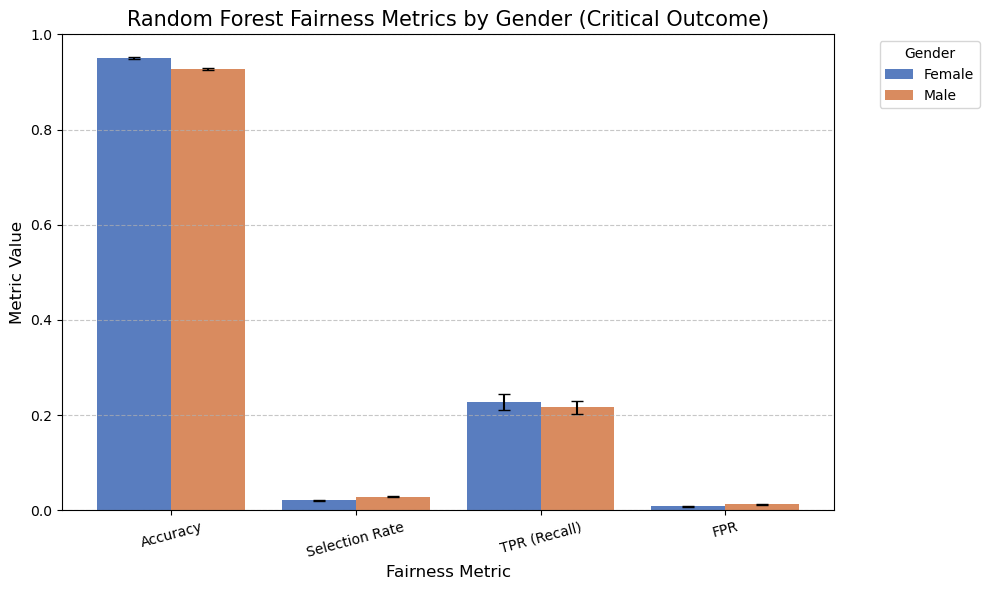

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_rf_gender_plot = []

for group, metric_dict in metrics.items(): 
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_rf_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_rf_gender_plot = pd.DataFrame(df_rf_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_rf_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_gender_plot['Metric'].unique()
group_list = df_rf_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_gender_plot[df_rf_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Random Forest Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Random Forest - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.916, CI = (0.914, 0.919)
Demographic Parity:    Mean = 0.027, CI = (0.018, 0.047)
Equal Opportunity:     Mean = 0.149, CI = (0.063, 0.315)
Equalized Odds:        Mean = 0.149, CI = (0.063, 0.315)


In [26]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Random Forest - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.905, CI = (0.901, 0.907)
Selection Rate    Mean = 0.032, CI = (0.031, 0.034)
TPR (Recall)      Mean = 0.197, CI = (0.185, 0.209)
FPR               Mean = 0.013, CI = (0.012, 0.015)

 Ethnicity: Black or African American
Accuracy          Mean = 0.938, CI = (0.934, 0.942)
Selection Rate    Mean = 0.018, CI = (0.016, 0.021)
TPR (Recall)      Mean = 0.167, CI = (0.143, 0.194)
FPR               Mean = 0.008, CI = (0.007, 0.010)

 Ethnicity: Asian
Accuracy          Mean = 0.915, CI = (0.902, 0.926)
Selection Rate    Mean = 0.032, CI = (0.024, 0.041)
TPR (Recall)      Mean = 0.237, CI = (0.179, 0.294)
FPR               Mean = 0.009, CI = (0.005, 0.014)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.951, CI = (0.944, 0.957)
Selection Rate    Mean = 0.014, CI = (0.011, 0.018)
TPR (Recall)      Mean = 0.156, CI = (0.110, 0.202)
FPR               Mean = 0.0

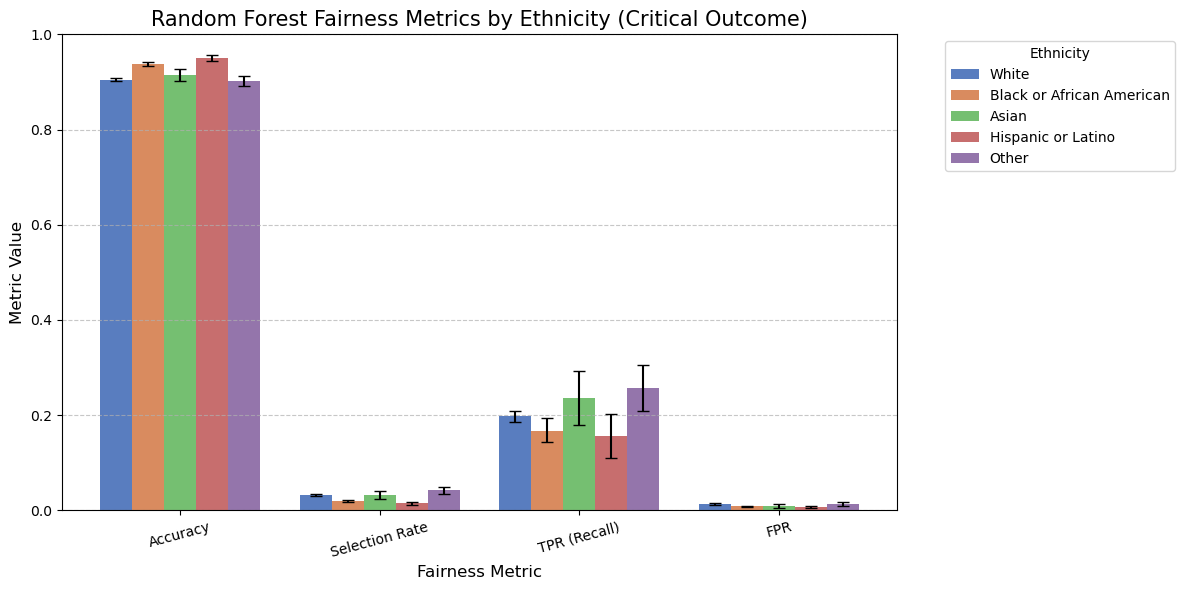

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_rf_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_rf_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_rf_ethnicity_plot = pd.DataFrame(df_rf_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_rf_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_ethnicity_plot['Metric'].unique()
group_list = df_rf_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_ethnicity_plot[df_rf_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Random Forest Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_raw = X_test['age']
valid_mask = age_raw.notna()

age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== Random Forest - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.939, CI = (0.937, 0.941)
Demographic Parity:    Mean = 0.164, CI = (0.084, 0.429)
Equal Opportunity:     Mean = 0.856, CI = (0.398, 1.000)
Equalized Odds:        Mean = 0.856, CI = (0.398, 1.000)


In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        metrics.append(metric)

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)

    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Random Forest - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.979, CI = (0.976, 0.982)
Selection Rate    Mean = 0.001, CI = (0.000, 0.002)
TPR (Recall)      Mean = 0.016, CI = (0.000, 0.036)
FPR               Mean = 0.001, CI = (0.000, 0.001)

Age Group: 25–34
Accuracy          Mean = 0.974, CI = (0.971, 0.977)
Selection Rate    Mean = 0.004, CI = (0.003, 0.005)
TPR (Recall)      Mean = 0.060, CI = (0.036, 0.089)
FPR               Mean = 0.002, CI = (0.002, 0.003)

Age Group: 35–44
Accuracy          Mean = 0.963, CI = (0.960, 0.967)
Selection Rate    Mean = 0.010, CI = (0.008, 0.012)
TPR (Recall)      Mean = 0.133, CI = (0.099, 0.168)
FPR               Mean = 0.005, CI = (0.004, 0.007)

Age Group: 45–54
Accuracy          Mean = 0.952, CI = (0.948, 0.

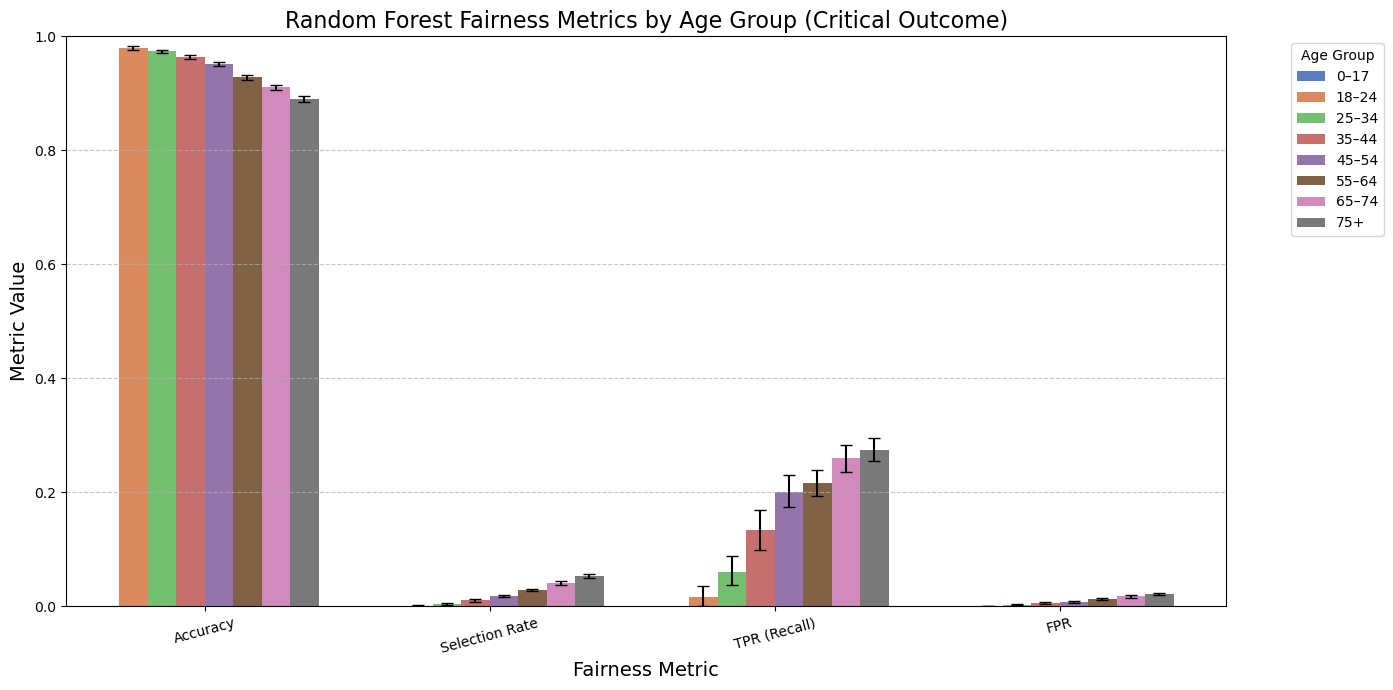

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_rf_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_rf_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_rf_age_plot = pd.DataFrame(df_rf_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_rf_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_age_plot['Metric'].unique()
group_list = df_rf_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_age_plot[df_rf_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Random Forest Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)

print("\n=== Random Forest - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===
Accuracy:              Mean = 0.845, CI = (0.841, 0.848)
Demographic Parity:    Mean = 0.003, CI = (0.001, 0.008)
Equal Opportunity:     Mean = 0.015, CI = (0.004, 0.031)
Equalized Odds:        Mean = 0.015, CI = (0.005, 0.031)


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))

    return values[0], mean, (ci_lower, ci_upper)

group_metrics = []
group_names = insurance_grouped.unique()

for group in group_names:
    mask = (insurance_grouped == group).values

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)

    group_metrics.append({
        'Insurance': group,
        'SR_Orig': sr_orig, 'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Orig': tpr_orig, 'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Orig': fpr_orig, 'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Orig': acc_orig, 'ACC_Mean': acc_mean, 'ACC_CI': acc_ci,
    })

df_insurance_metrics = pd.DataFrame(group_metrics)

print("\n=== Random Forest - Fairness Metrics by Insurance Group for Critical Outcome ===")

print("\n=== Accuracy by Insurance Group ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['ACC_CI']
    print(f"{row['Insurance']}: Mean = {row['ACC_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Demographic Parity (Selection Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['SR_CI']
    print(f"{row['Insurance']}: Mean = {row['SR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equal Opportunity (True Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['TPR_CI']
    print(f"{row['Insurance']}: Mean = {row['TPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equalized Odds (False Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['FPR_CI']
    print(f"{row['Insurance']}: Mean = {row['FPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Fairness Metrics by Insurance Group for Critical Outcome ===

=== Accuracy by Insurance Group ===
Medicaid: Mean = 0.893, CI = (0.884, 0.903)
Medicare: Mean = 0.863, CI = (0.857, 0.868)
Other: Mean = 0.888, CI = (0.884, 0.892)

=== Demographic Parity (Selection Rate) ===
Medicaid: Mean = 0.030, CI = (0.025, 0.036)
Medicare: Mean = 0.056, CI = (0.052, 0.059)
Other: Mean = 0.038, CI = (0.035, 0.040)

=== Equal Opportunity (True Positive Rate) ===
Medicaid: Mean = 0.185, CI = (0.148, 0.220)
Medicare: Mean = 0.248, CI = (0.232, 0.264)
Other: Mean = 0.202, CI = (0.188, 0.217)

=== Equalized Odds (False Positive Rate) ===
Medicaid: Mean = 0.009, CI = (0.006, 0.013)
Medicare: Mean = 0.019, CI = (0.016, 0.021)
Other: Mean = 0.015, CI = (0.013, 0.016)


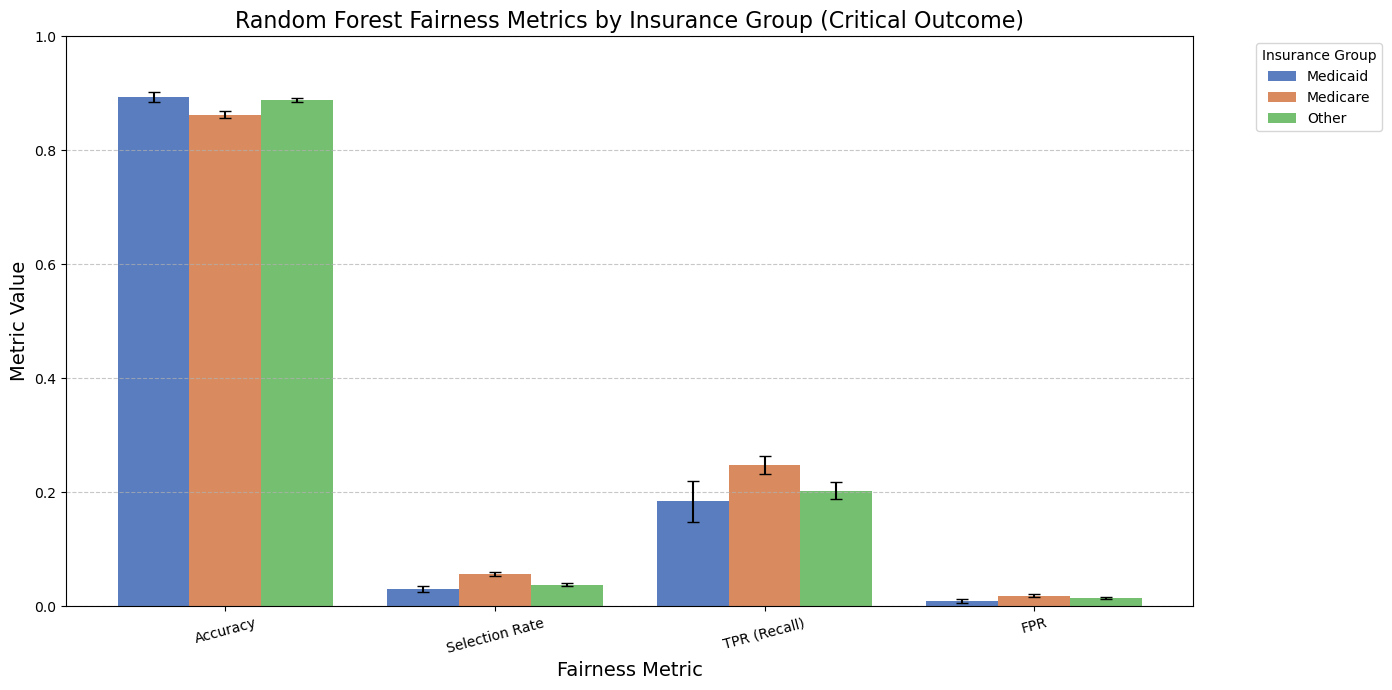

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_rf_insurance_plot = pd.DataFrame({
    'Group': list(df_insurance_metrics['Insurance']) * 4,
    'Metric': ['Accuracy'] * len(df_insurance_metrics) +
              ['Selection Rate'] * len(df_insurance_metrics) +
              ['TPR (Recall)'] * len(df_insurance_metrics) +
              ['FPR'] * len(df_insurance_metrics),
    'Mean': list(df_insurance_metrics['ACC_Mean']) +
            list(df_insurance_metrics['SR_Mean']) +
            list(df_insurance_metrics['TPR_Mean']) +
            list(df_insurance_metrics['FPR_Mean']),
    'Lower': [ci[0] for ci in df_insurance_metrics['ACC_CI']] +
             [ci[0] for ci in df_insurance_metrics['SR_CI']] +
             [ci[0] for ci in df_insurance_metrics['TPR_CI']] +
             [ci[0] for ci in df_insurance_metrics['FPR_CI']],
    'Upper': [ci[1] for ci in df_insurance_metrics['ACC_CI']] +
             [ci[1] for ci in df_insurance_metrics['SR_CI']] +
             [ci[1] for ci in df_insurance_metrics['TPR_CI']] +
             [ci[1] for ci in df_insurance_metrics['FPR_CI']]
})

df_rf_insurance_plot['Error Lower'] = df_rf_insurance_plot['Mean'] - df_rf_insurance_plot['Lower']
df_rf_insurance_plot['Error Upper'] = df_rf_insurance_plot['Upper'] - df_rf_insurance_plot['Mean']

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_rf_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2,
    order=['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR'] 
)

metric_list = ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']
group_list = df_rf_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_insurance_plot[df_rf_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Random Forest Fairness Metrics by Insurance Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


GradientBoosting:
Training time: 68.3980622291565 seconds
AUC: 0.8936031216743434
AUPRC: 0.43713339445097193
Sensitivity: 0.8242240215924427
Specificity: 0.8042298378919995
Score thresold: 0.07080329280150088
2.5 97.5


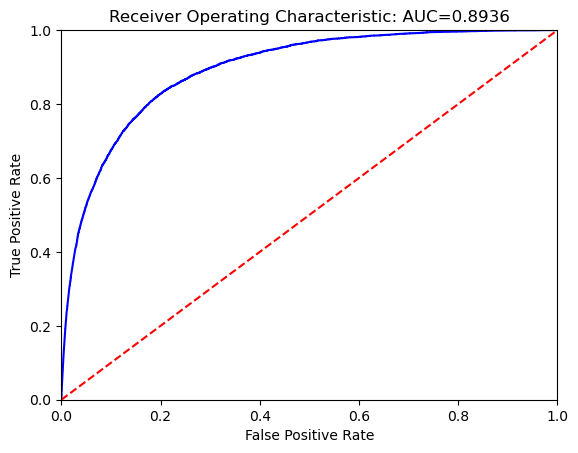

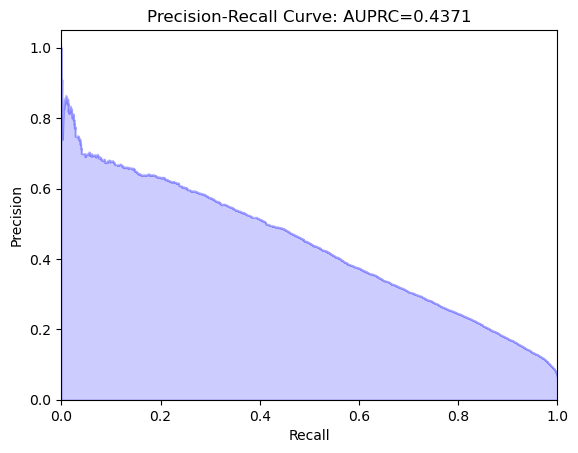

In [34]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [35]:
probs = gb.predict_proba(X_test)  
y_pred = (probs[:, 1] >= 0.5).astype(int)

In [36]:

import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    values = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)

    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sf_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sf_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))

    return mean_val, (ci_lower, ci_upper)

In [37]:
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

metrics_summary = {
    "Accuracy": (acc_mean, acc_ci),
    "Demographic Parity": (dpd_mean, dpd_ci),
    "Equal Opportunity": (eopp_mean, eopp_ci),
    "Equalized Odds": (eod_mean, eod_ci)
}

print("\n=== Gradient Boosting - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
for name, (mean, (ci_low, ci_high)) in metrics_summary.items():
    print(f"{name:<22} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy               Mean = 0.940, CI = (0.938, 0.941)
Demographic Parity     Mean = 0.008, CI = (0.006, 0.010)
Equal Opportunity      Mean = 0.015, CI = (0.001, 0.034)
Equalized Odds         Mean = 0.015, CI = (0.003, 0.034)


In [38]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Gradient Boosting Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.950, CI = (0.948, 0.952)
Selection Rate   Mean = 0.021, CI = (0.020, 0.023)
TPR (Recall)     Mean = 0.243, CI = (0.226, 0.259)
FPR              Mean = 0.009, CI = (0.008, 0.009)

Male:
Accuracy         Mean = 0.927, CI = (0.925, 0.930)
Selection Rate   Mean = 0.030, CI = (0.028, 0.031)
TPR (Recall)     Mean = 0.229, CI = (0.215, 0.242)
FPR              Mean = 0.013, CI = (0.012, 0.014)


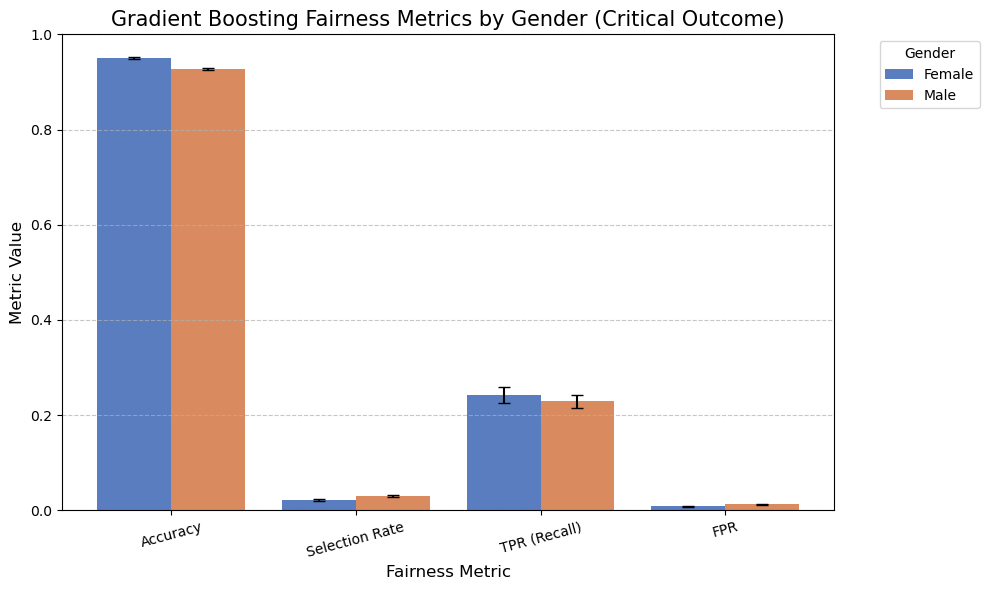

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_gb_gender_plot = []

for group, metric_dict in metrics.items(): 
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_gb_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_gb_gender_plot = pd.DataFrame(df_gb_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_gb_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_gb_gender_plot['Metric'].unique()
group_list = df_gb_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_gender_plot[df_gb_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [40]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Gradient Boosting - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.917, CI = (0.914, 0.919)
Demographic Parity:    Mean = 0.030, CI = (0.020, 0.060)
Equal Opportunity:     Mean = 0.179, CI = (0.095, 0.354)
Equalized Odds:        Mean = 0.179, CI = (0.095, 0.354)


In [41]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0


def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Gradient Boosting - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.905, CI = (0.902, 0.909)
Selection Rate    Mean = 0.036, CI = (0.034, 0.038)
TPR (Recall)      Mean = 0.218, CI = (0.205, 0.232)
FPR               Mean = 0.015, CI = (0.013, 0.016)

 Ethnicity: Black or African American
Accuracy          Mean = 0.940, CI = (0.936, 0.944)
Selection Rate    Mean = 0.022, CI = (0.020, 0.025)
TPR (Recall)      Mean = 0.207, CI = (0.178, 0.235)
FPR               Mean = 0.009, CI = (0.008, 0.011)

 Ethnicity: Asian
Accuracy          Mean = 0.914, CI = (0.902, 0.927)
Selection Rate    Mean = 0.036, CI = (0.028, 0.044)
TPR (Recall)      Mean = 0.253, CI = (0.194, 0.316)
FPR               Mean = 0.011, CI = (0.007, 0.016)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.947, CI = (0.941, 0.954)
Selection Rate    Mean = 0.014, CI = (0.011, 0.017)
TPR (Recall)      Mean = 0.117, CI = (0.074, 0.161)
FPR               Mean =

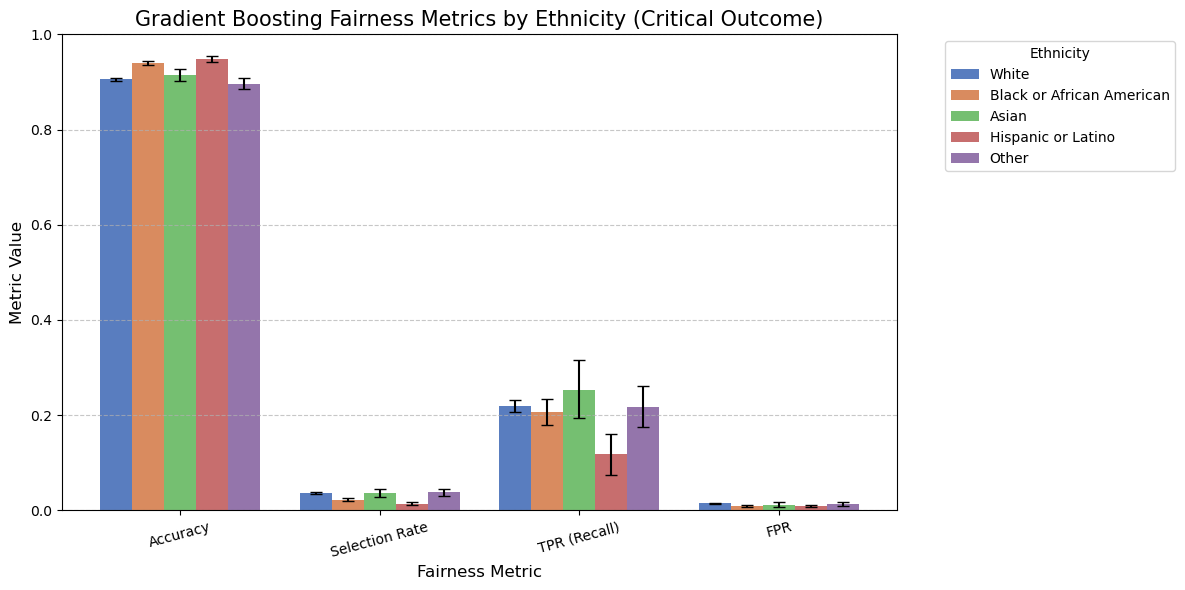

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_gb_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_gb_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_gb_ethnicity_plot = pd.DataFrame(df_gb_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_gb_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_gb_ethnicity_plot['Metric'].unique()
group_list = df_gb_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_ethnicity_plot[df_gb_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [60]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

age_raw = X_test['age']
valid_mask = age_raw.notna()
age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== Gradient Boosting - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.940, CI = (0.938, 0.941)
Demographic Parity:    Mean = 0.167, CI = (0.090, 0.429)
Equal Opportunity:     Mean = 0.861, CI = (0.430, 1.000)
Equalized Odds:        Mean = 0.861, CI = (0.430, 1.000)


In [61]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)
    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Gradient Boosting - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.980, CI = (0.977, 0.983)
Selection Rate    Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.026, CI = (0.005, 0.051)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.975, CI = (0.972, 0.977)
Selection Rate    Mean = 0.002, CI = (0.001, 0.003)
TPR (Recall)      Mean = 0.036, CI = (0.018, 0.057)
FPR               Mean = 0.001, CI = (0.001, 0.002)

Age Group: 35–44
Accuracy          Mean = 0.965, CI = (0.961, 0.968)
Selection Rate    Mean = 0.003, CI = (0.002, 0.004)
TPR (Recall)      Mean = 0.054, CI = (0.032, 0.078)
FPR               Mean = 0.001, CI = (0.000, 0.001)

Age Group: 45–54
Accuracy          Mean = 0.953, CI = (0.949

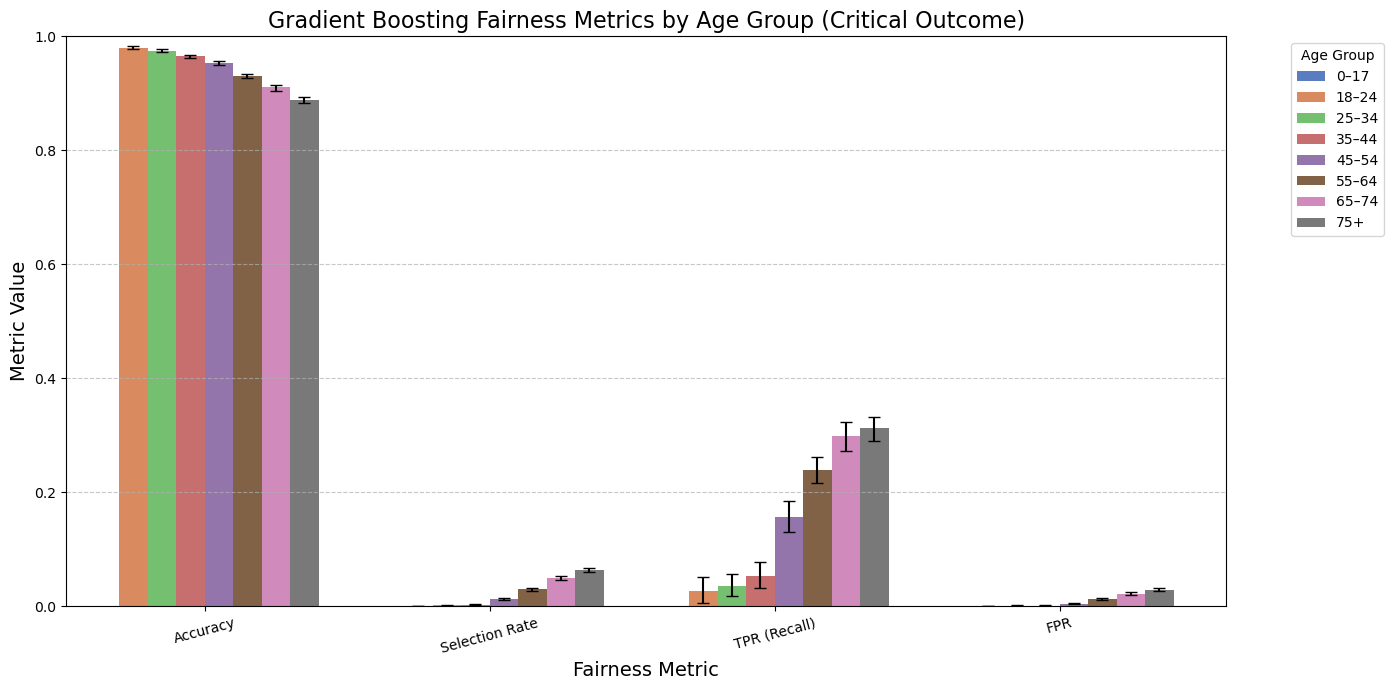

In [62]:
df_gb_age_plot = []

for row in group_metrics: 
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_gb_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_gb_age_plot = pd.DataFrame(df_gb_age_plot)

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_gb_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_gb_age_plot['Metric'].unique()
group_list = df_gb_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_age_plot[df_gb_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Gradient Boosting Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)

print("\n=== Gradient Boosting - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===
Accuracy:              Mean = 0.880, CI = (0.876, 0.883)
Demographic Parity:    Mean = 0.040, CI = (0.033, 0.046)
Equal Opportunity:     Mean = 0.126, CI = (0.089, 0.160)
Equalized Odds:        Mean = 0.126, CI = (0.089, 0.160)


In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)

insurance_raw = df_test['insurance']
valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return values[0], mean, (ci_lower, ci_upper)

group_metrics = []
group_names = insurance_grouped.unique()

for group in group_names:
    mask = (insurance_grouped == group).values

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)

    group_metrics.append({
        'Insurance': group,
        'SR_Orig': sr_orig, 'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Orig': tpr_orig, 'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Orig': fpr_orig, 'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Orig': acc_orig, 'ACC_Mean': acc_mean, 'ACC_CI': acc_ci,
    })

df_insurance_metrics = pd.DataFrame(group_metrics)

print("\n=== Gradient Boosting - Fairness Metrics by Insurance Group for Critical Outcome ===")

print("\n=== Accuracy by Insurance Group ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['ACC_CI']
    print(f"{row['Insurance']}: Mean = {row['ACC_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Demographic Parity (Selection Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['SR_CI']
    print(f"{row['Insurance']}: Mean = {row['SR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equal Opportunity (True Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['TPR_CI']
    print(f"{row['Insurance']}: Mean = {row['TPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equalized Odds (False Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['FPR_CI']
    print(f"{row['Insurance']}: Mean = {row['FPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Fairness Metrics by Insurance Group for Critical Outcome ===

=== Accuracy by Insurance Group ===
Medicaid: Mean = 0.891, CI = (0.881, 0.901)
Medicare: Mean = 0.863, CI = (0.858, 0.868)
Other: Mean = 0.890, CI = (0.886, 0.894)

=== Demographic Parity (Selection Rate) ===
Medicaid: Mean = 0.026, CI = (0.021, 0.031)
Medicare: Mean = 0.066, CI = (0.062, 0.070)
Other: Mean = 0.037, CI = (0.034, 0.039)

=== Equal Opportunity (True Positive Rate) ===
Medicaid: Mean = 0.155, CI = (0.124, 0.190)
Medicare: Mean = 0.281, CI = (0.263, 0.298)
Other: Mean = 0.205, CI = (0.191, 0.221)

=== Equalized Odds (False Positive Rate) ===
Medicaid: Mean = 0.008, CI = (0.005, 0.011)
Medicare: Mean = 0.025, CI = (0.022, 0.027)
Other: Mean = 0.013, CI = (0.012, 0.015)


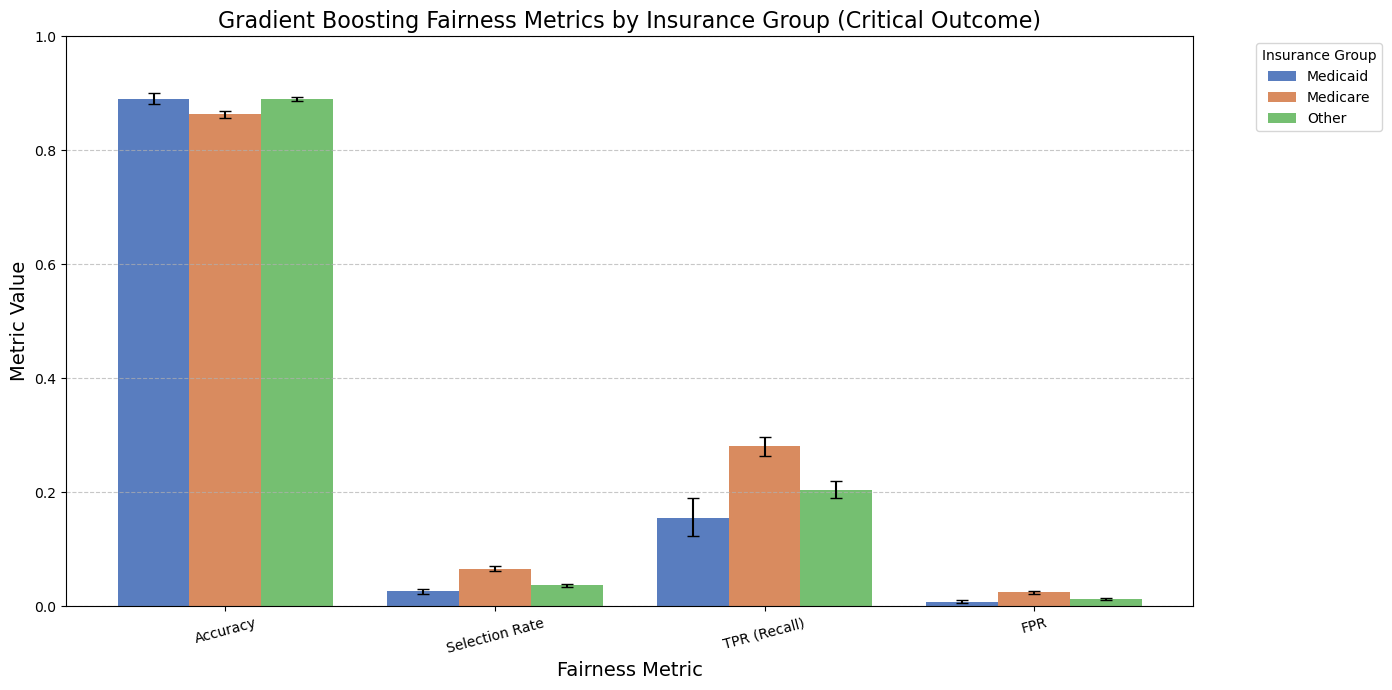

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_gb_insurance_plot = pd.DataFrame({
    'Group': list(df_insurance_metrics['Insurance']) * 4,
    'Metric': ['Accuracy'] * len(df_insurance_metrics) +
              ['Selection Rate'] * len(df_insurance_metrics) +
              ['TPR (Recall)'] * len(df_insurance_metrics) +
              ['FPR'] * len(df_insurance_metrics),
    'Mean': list(df_insurance_metrics['ACC_Mean']) +
            list(df_insurance_metrics['SR_Mean']) +
            list(df_insurance_metrics['TPR_Mean']) +
            list(df_insurance_metrics['FPR_Mean']),
    'Lower': [ci[0] for ci in df_insurance_metrics['ACC_CI']] +
             [ci[0] for ci in df_insurance_metrics['SR_CI']] +
             [ci[0] for ci in df_insurance_metrics['TPR_CI']] +
             [ci[0] for ci in df_insurance_metrics['FPR_CI']],
    'Upper': [ci[1] for ci in df_insurance_metrics['ACC_CI']] +
             [ci[1] for ci in df_insurance_metrics['SR_CI']] +
             [ci[1] for ci in df_insurance_metrics['TPR_CI']] +
             [ci[1] for ci in df_insurance_metrics['FPR_CI']]
})

df_gb_insurance_plot['Error Lower'] = df_gb_insurance_plot['Mean'] - df_gb_insurance_plot['Lower']
df_gb_insurance_plot['Error Upper'] = df_gb_insurance_plot['Upper'] - df_gb_insurance_plot['Mean']

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_gb_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2,
    order=['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR'] 
)

metric_list = ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']
group_list = df_gb_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_insurance_plot[df_gb_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Gradient Boosting Fairness Metrics by Insurance Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class MLP(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [49]:
from tensorflow.keras import metrics, optimizers

mlp = MLP()
mlp.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.AUC(name='auprc', curve='PR'),
        metrics.TruePositives(name='tp'),
        metrics.TrueNegatives(name='tn'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)


In [14]:
# class MLP(tf.keras.Model):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.dense_1 = Dense(128, activation='relu')
#         self.dense_2 = Dense(64, activation='relu')
#         self.classifier = Dense(1, activation='sigmoid')

#     def call(self, x):
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         return self.classifier(x)

In [51]:
# skip this cell if not retraining
# mlp = MLP()
# mlp.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp.keras')

Epoch 1/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9387 - auc: 0.8864 - auprc: 0.4270 - loss: 0.1681 - precision: 0.6118 - recall: 0.2115 - tn: 166230.4219 - tp: 2554.7068
Epoch 2/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9376 - auc: 0.8842 - auprc: 0.4135 - loss: 0.1708 - precision: 0.6029 - recall: 0.1984 - tn: 166224.0938 - tp: 2473.6467
Epoch 3/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9396 - auc: 0.8892 - auprc: 0.4283 - loss: 0.1655 - precision: 0.6085 - recall: 0.2243 - tn: 166211.2969 - tp: 2669.5781
Epoch 4/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9393 - auc: 0.8892 - auprc: 0.4233 - loss: 0.1659 - precision: 0.6011 - recall: 0.2232 - tn: 166229.6719 - tp: 2662.7842
Epoch 5/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9387 - auc: 0.8885 - auprc: 0.4213 - loss: 0.1669 - precision: 0.6009 - recall: 0.2130 - tn: 166281.5781 - tp: 2579.5781
Epoch 6/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step -

MLP:
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step
AUC: 0.883905803232965
AUPRC: 0.3956261676102482
Sensitivity: 0.8068488529014844
Specificity: 0.7964643994608328
Score thresold: 0.07239867
2.5 97.5


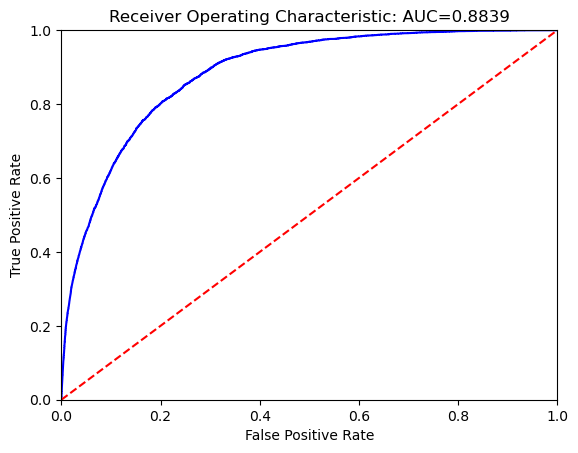

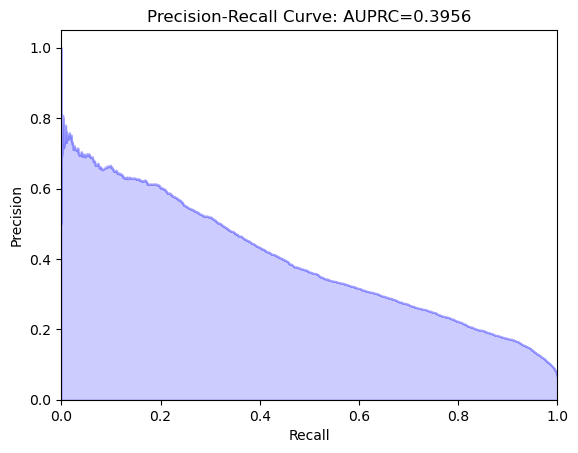

In [52]:
print("MLP:")
mlp = load_model('critical_triage_mlp.keras')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [53]:
def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    values = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)
    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sf_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sf_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

In [54]:
import numpy as np
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

metrics_summary = {
    "Accuracy": (acc_mean, acc_ci),
    "Demographic Parity": (dpd_mean, dpd_ci),
    "Equal Opportunity": (eopp_mean, eopp_ci),
    "Equalized Odds": (eod_mean, eod_ci)
}

print("\n=== MLP - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===")
for name, (mean, (ci_low, ci_high)) in metrics_summary.items():
    print(f"{name:<22} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step

=== MLP - Fairness Metrics by Gender for Critical Outcome (Mean + 95% CI) ===
Accuracy               Mean = 0.938, CI = (0.936, 0.940)
Demographic Parity     Mean = 0.005, CI = (0.004, 0.007)
Equal Opportunity      Mean = 0.008, CI = (0.000, 0.022)
Equalized Odds         Mean = 0.008, CI = (0.002, 0.022)


In [55]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== MLP Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step

=== MLP Per-Gender Metrics for Critical Outcome (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.948, CI = (0.947, 0.950)
Selection Rate   Mean = 0.013, CI = (0.012, 0.014)
TPR (Recall)     Mean = 0.150, CI = (0.136, 0.166)
FPR              Mean = 0.005, CI = (0.005, 0.006)

Male:
Accuracy         Mean = 0.926, CI = (0.923, 0.928)
Selection Rate   Mean = 0.019, CI = (0.017, 0.020)
TPR (Recall)     Mean = 0.148, CI = (0.135, 0.160)
FPR              Mean = 0.007, CI = (0.007, 0.008)


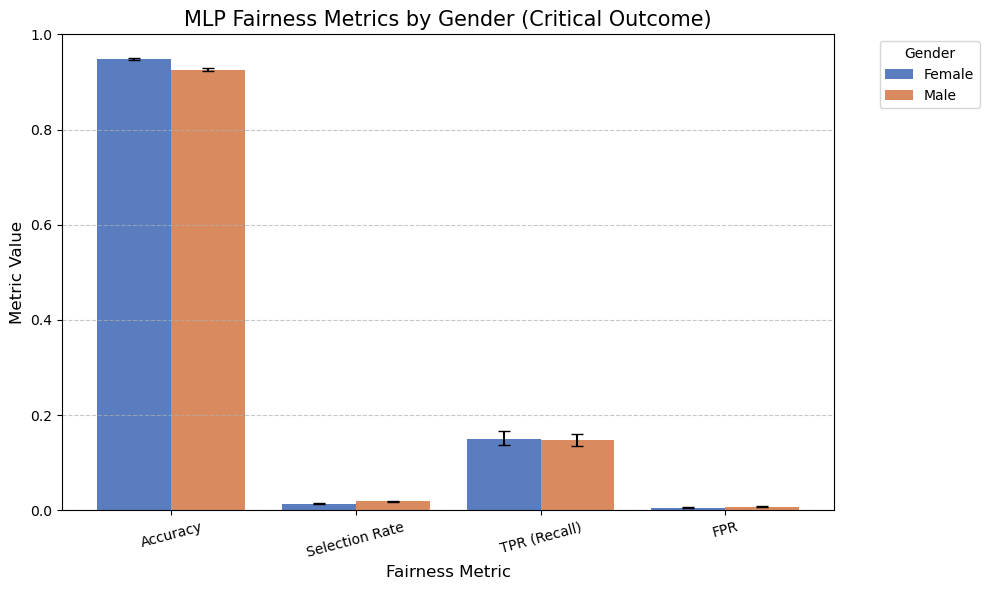

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare plotting DataFrame
df_mlp_gender_plot = []

for group, metric_dict in metrics.items(): 
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_mlp_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_gender_plot = pd.DataFrame(df_mlp_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_mlp_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_mlp_gender_plot['Metric'].unique()
group_list = df_mlp_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_gender_plot[df_mlp_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('MLP Fairness Metrics by Gender (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [57]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score
import numpy as np

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask]

ethnicity_grouped = ethnicity_clean.str.upper()

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== MLP - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step

=== MLP - Fairness Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===
Accuracy:              Mean = 0.914, CI = (0.911, 0.916)
Demographic Parity:    Mean = 0.019, CI = (0.012, 0.028)
Equal Opportunity:     Mean = 0.178, CI = (0.143, 0.227)
Equalized Odds:        Mean = 0.178, CI = (0.143, 0.227)


In [58]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)

ethnicity_raw = df_test['ethnicity']
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step

=== MLP - Metrics by Ethnicity for Critical Outcome (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.901, CI = (0.898, 0.904)
Selection Rate    Mean = 0.023, CI = (0.022, 0.025)
TPR (Recall)      Mean = 0.139, CI = (0.129, 0.150)
FPR               Mean = 0.010, CI = (0.009, 0.011)

 Ethnicity: Black or African American
Accuracy          Mean = 0.939, CI = (0.935, 0.943)
Selection Rate    Mean = 0.014, CI = (0.012, 0.016)
TPR (Recall)      Mean = 0.142, CI = (0.118, 0.166)
FPR               Mean = 0.005, CI = (0.004, 0.006)

 Ethnicity: Asian
Accuracy          Mean = 0.912, CI = (0.900, 0.924)
Selection Rate    Mean = 0.022, CI = (0.016, 0.029)
TPR (Recall)      Mean = 0.175, CI = (0.120, 0.229)
FPR               Mean = 0.005, CI = (0.002, 0.009)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.948, CI = (0.941, 0.954)
Selection Rate    Mean = 0.010, CI = (0.007, 0.013)
TPR (Recall)      Mean = 0.090, CI = (0.056, 

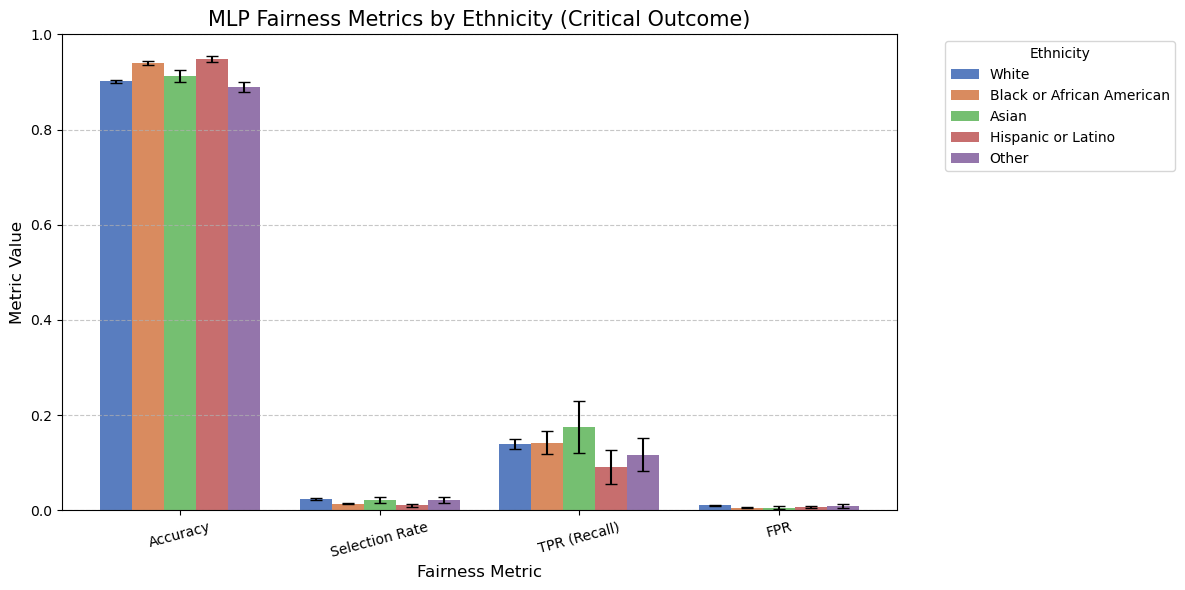

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_ethnicity_plot = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']: 
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_ethnicity_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_ethnicity_plot = pd.DataFrame(df_mlp_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_mlp_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_mlp_ethnicity_plot['Metric'].unique()
group_list = df_mlp_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_ethnicity_plot[df_mlp_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('MLP Fairness Metrics by Ethnicity (Critical Outcome)', fontsize=15)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [63]:
probs = mlp.predict(X_test.astype(np.float32))
if probs.shape[1] == 1:
    probs = probs[:, 0]
y_pred = (probs >= 0.5).astype(int)


age_raw = X_test['age']
valid_mask = age_raw.notna()
age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=age_clean)

print("\n=== MLP - Bootstrapped Fairness Metrics by Age for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step

=== MLP - Bootstrapped Fairness Metrics by Age for Critical Outcome ===
Accuracy:              Mean = 0.938, CI = (0.936, 0.940)
Demographic Parity:    Mean = 0.084, CI = (0.067, 0.114)
Equal Opportunity:     Mean = 0.585, CI = (0.300, 1.000)
Equalized Odds:        Mean = 0.585, CI = (0.300, 1.000)


In [64]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

group_metrics = []

for group in age_labels:
    group_mask = (age_grouped_clean == group)
    if group_mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, group_mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, group_mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, group_mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, group_mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP - Bootstrapped Metrics by Age Group for Critical Outcome (Mean + 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.980, CI = (0.977, 0.983)
Selection Rate    Mean = 0.001, CI = (0.000, 0.001)
TPR (Recall)      Mean = 0.026, CI = (0.005, 0.051)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Age Group: 25–34
Accuracy          Mean = 0.975, CI = (0.972, 0.977)
Selection Rate    Mean = 0.001, CI = (0.001, 0.002)
TPR (Recall)      Mean = 0.024, CI = (0.009, 0.042)
FPR               Mean = 0.001, CI = (0.000, 0.001)

Age Group: 35–44
Accuracy          Mean = 0.964, CI = (0.961, 0.968)
Selection Rate    Mean = 0.003, CI = (0.002, 0.004)
TPR (Recall)      Mean = 0.049, CI = (0.028, 0.072)
FPR               Mean = 0.001, CI = (0.001, 0.002)

Age Group: 45–54
Accuracy          Mean = 0.951, CI = (0.947, 0.955)
Selec

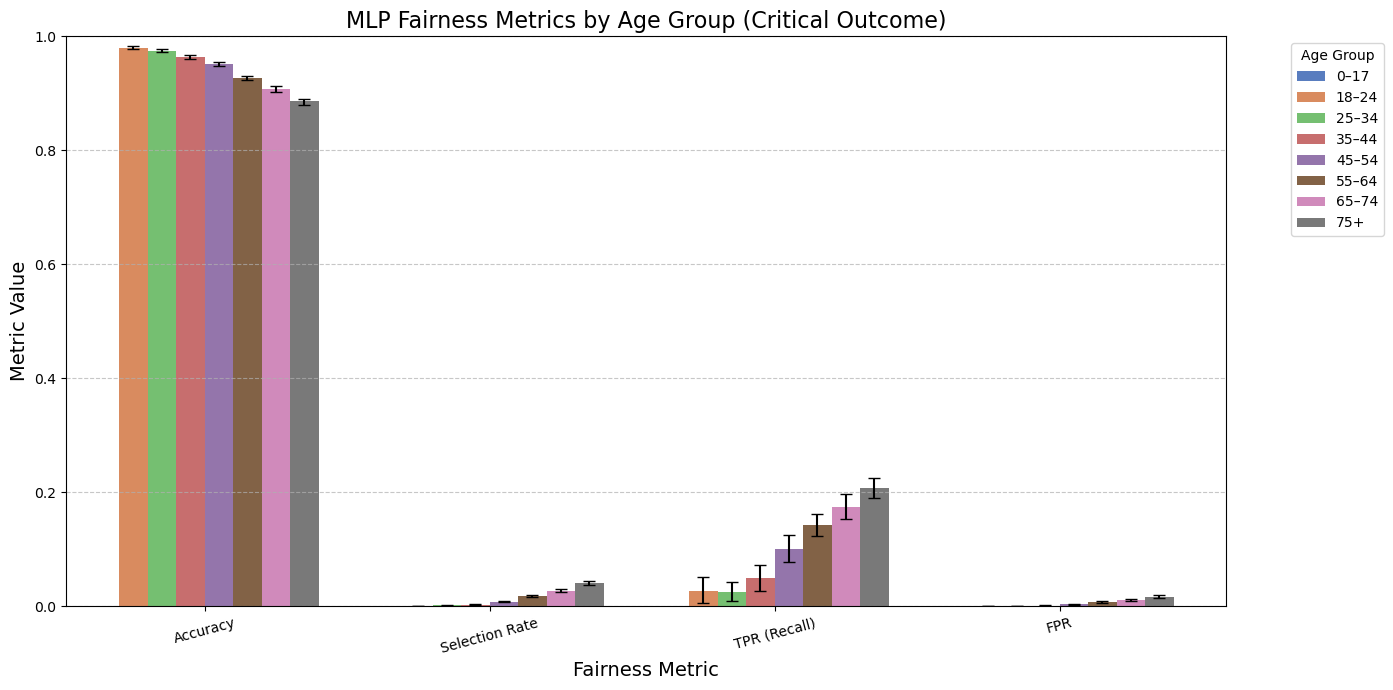

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_age_plot = pd.DataFrame(df_mlp_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_mlp_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_mlp_age_plot['Metric'].unique()
group_list = df_mlp_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_age_plot[df_mlp_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('MLP Fairness Metrics by Age Group (Critical Outcome)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [67]:
insurance_raw = df_test['insurance']
valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped
)

print("\n=== MLP - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== MLP - Bootstrapped Fairness & Accuracy Metrics by Insurance for Critical Outcome ===
Accuracy:              Mean = 0.872, CI = (0.869, 0.876)
Demographic Parity:    Mean = 0.028, CI = (0.023, 0.033)
Equal Opportunity:     Mean = 0.086, CI = (0.055, 0.116)
Equalized Odds:        Mean = 0.086, CI = (0.055, 0.116)


In [68]:
insurance_raw = df_test['insurance']
valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return values[0], mean, (ci_lower, ci_upper)

group_metrics = []
group_names = insurance_grouped.unique()

for group in group_names:
    mask = (insurance_grouped == group).values

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)

    group_metrics.append({
        'Insurance': group,
        'SR_Orig': sr_orig, 'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Orig': tpr_orig, 'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Orig': fpr_orig, 'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Orig': acc_orig, 'ACC_Mean': acc_mean, 'ACC_CI': acc_ci,
    })

df_insurance_metrics = pd.DataFrame(group_metrics)

print("\n=== MLP - Fairness Metrics by Insurance Group for Critical Outcome ===")

print("\n=== Accuracy by Insurance Group ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['ACC_CI']
    print(f"{row['Insurance']}: Mean = {row['ACC_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Demographic Parity (Selection Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['SR_CI']
    print(f"{row['Insurance']}: Mean = {row['SR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equal Opportunity (True Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['TPR_CI']
    print(f"{row['Insurance']}: Mean = {row['TPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equalized Odds (False Positive Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['FPR_CI']
    print(f"{row['Insurance']}: Mean = {row['FPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP - Fairness Metrics by Insurance Group for Critical Outcome ===

=== Accuracy by Insurance Group ===
Medicaid: Mean = 0.887, CI = (0.877, 0.896)
Medicare: Mean = 0.853, CI = (0.847, 0.858)
Other: Mean = 0.884, CI = (0.880, 0.888)

=== Demographic Parity (Selection Rate) ===
Medicaid: Mean = 0.015, CI = (0.011, 0.019)
Medicare: Mean = 0.043, CI = (0.040, 0.046)
Other: Mean = 0.024, CI = (0.022, 0.026)

=== Equal Opportunity (True Positive Rate) ===
Medicaid: Mean = 0.093, CI = (0.067, 0.119)
Medicare: Mean = 0.178, CI = (0.164, 0.192)
Other: Mean = 0.130, CI = (0.117, 0.142)

=== Equalized Odds (False Positive Rate) ===
Medicaid: Mean = 0.004, CI = (0.002, 0.007)
Medicare: Mean = 0.017, CI = (0.015, 0.019)
Other: Mean = 0.008, CI = (0.007, 0.010)


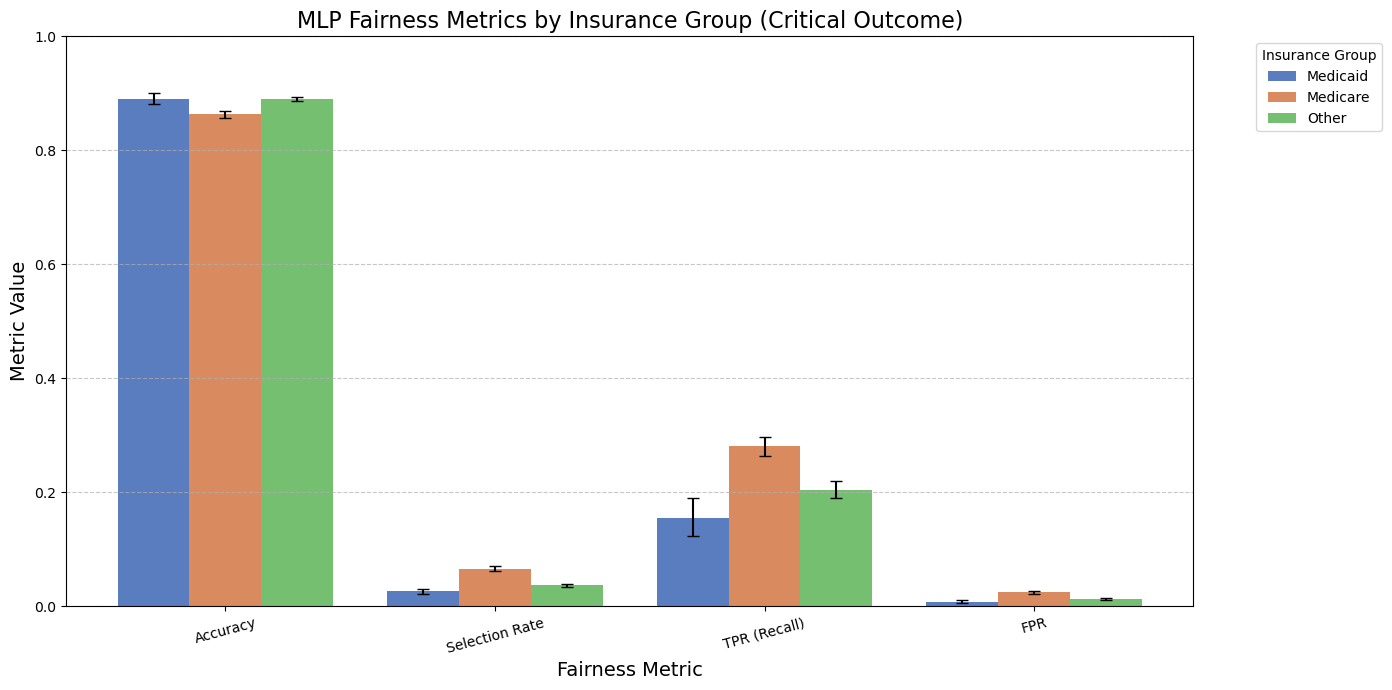

In [69]:
plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_gb_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2,
    order=['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR'] 
)

metric_list = ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']
group_list = df_gb_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_insurance_plot[df_gb_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width / 2 + j * group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('MLP Fairness Metrics by Insurance Group (Critical Outcome)', fontsize=16)  # <-- UPDATED
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.789785904244466
AUPRC: 0.19449354874032998
Sensitivity: 0.8959176788124157
Specificity: 0.6333186215452149
Score thresold: -2.6248987751080204
2.5 97.5


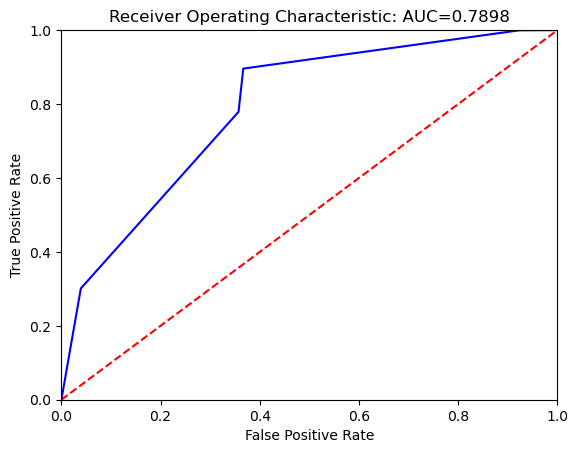

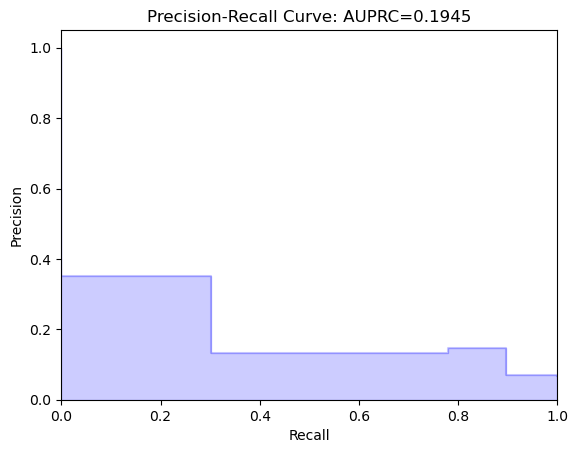

In [12]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

In [14]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    boot_metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        if sensitive_features is not None:
            metric_value = metric_func(
                y_true[idx], y_pred[idx], sensitive_features=sensitive_features[idx]
            )
        else:
            metric_value = metric_func(y_true[idx], y_pred[idx])
        boot_metrics.append(metric_value)

    lower = np.percentile(boot_metrics, 100 * (alpha / 2))
    upper = np.percentile(boot_metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(boot_metrics)
    
    return mean_val, (lower, upper)


In [15]:
import numpy as np

threshold_value = np.percentile(df_test["ESI"], 70) 
y_pred_esi = (df_test["ESI"] >= threshold_value).astype(int)

gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred_esi[valid_mask] 
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

print("\n=== ESI - Fairness Metrics by Gender (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Fairness Metrics by Gender (Mean + 95% CI) ===
Accuracy:              Mean = 0.652, CI = (0.649, 0.655)
Demographic Parity:    Mean = 0.054, CI = (0.048, 0.061)
Equal Opportunity:     Mean = 0.017, CI = (0.001, 0.037)
Equalized Odds:        Mean = 0.049, CI = (0.043, 0.055)


In [16]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== ESI Per-Gender Metrics (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI Per-Gender Metrics (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.672, CI = (0.667, 0.676)
Selection Rate   Mean = 0.360, CI = (0.356, 0.364)
TPR (Recall)     Mean = 0.788, CI = (0.772, 0.803)
FPR              Mean = 0.335, CI = (0.331, 0.340)

Male:
Accuracy         Mean = 0.629, CI = (0.624, 0.633)
Selection Rate   Mean = 0.414, CI = (0.409, 0.419)
TPR (Recall)     Mean = 0.772, CI = (0.758, 0.786)
FPR              Mean = 0.384, CI = (0.379, 0.388)


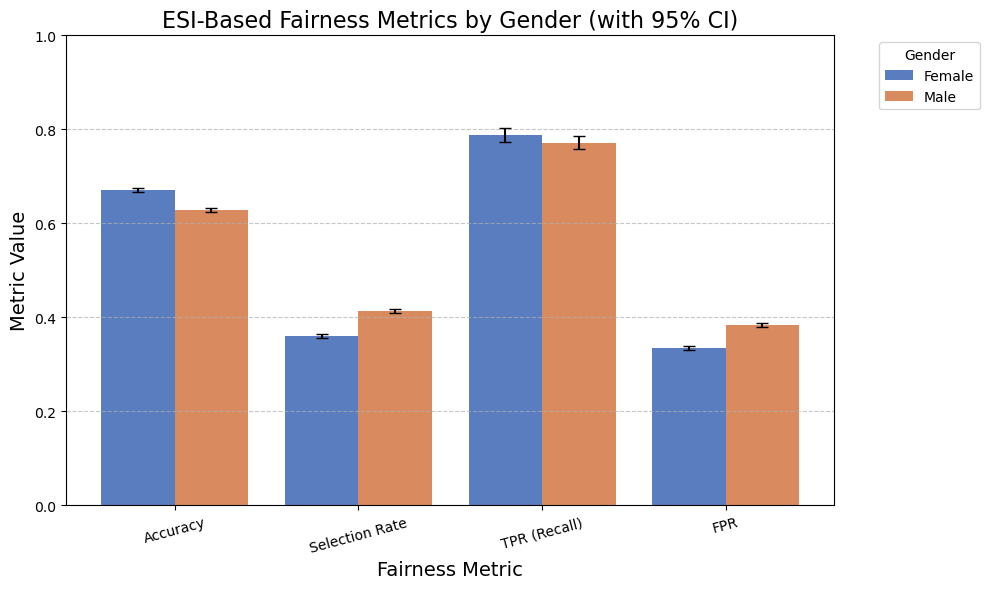

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_esi_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_esi_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_gender_plot = pd.DataFrame(df_esi_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_esi_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None, 
    capsize=0.2
)

metric_list = df_esi_gender_plot['Metric'].unique()
group_list = df_esi_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_esi_gender_plot[df_esi_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Gender (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [18]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

threshold_value = np.percentile(df_test["ESI"], 70)  
y_pred_esi = (df_test["ESI"] >= threshold_value).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (ethnicity_raw.str.lower() != 'unknown')
)

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_esi[valid_mask]  # <== Now ESI-based predictions

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== ESI - Fairness Metrics by Ethnicity (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Fairness Metrics by Ethnicity (Mean + 95% CI) ===
Accuracy:              Mean = 0.575, CI = (0.571, 0.579)
Demographic Parity:    Mean = 0.132, CI = (0.115, 0.149)
Equal Opportunity:     Mean = 0.132, CI = (0.072, 0.198)
Equalized Odds:        Mean = 0.139, CI = (0.108, 0.198)


In [19]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== ESI - Metrics by Ethnicity Group (Mean + 95% CI) ===")  
for row in ethnicity_metrics:
    print(f"\nEthnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI - Metrics by Ethnicity Group (Mean + 95% CI) ===

Ethnicity: White
Accuracy          Mean = 0.549, CI = (0.544, 0.554)
Selection Rate    Mean = 0.514, CI = (0.509, 0.519)
TPR (Recall)      Mean = 0.803, CI = (0.790, 0.817)
FPR               Mean = 0.480, CI = (0.475, 0.486)

Ethnicity: Black or African American
Accuracy          Mean = 0.628, CI = (0.619, 0.636)
Selection Rate    Mean = 0.409, CI = (0.401, 0.419)
TPR (Recall)      Mean = 0.785, CI = (0.758, 0.811)
FPR               Mean = 0.383, CI = (0.374, 0.392)

Ethnicity: Asian
Accuracy          Mean = 0.565, CI = (0.544, 0.587)
Selection Rate    Mean = 0.505, CI = (0.483, 0.526)
TPR (Recall)      Mean = 0.846, CI = (0.798, 0.893)
FPR               Mean = 0.466, CI = (0.443, 0.489)

Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.642, CI = (0.627, 0.656)
Selection Rate    Mean = 0.384, CI = (0.370, 0.399)
TPR (Recall)      Mean = 0.757, CI = (0.698, 0.811)
FPR               Mean = 0.364, CI = (0.350, 0.379)

Ethn

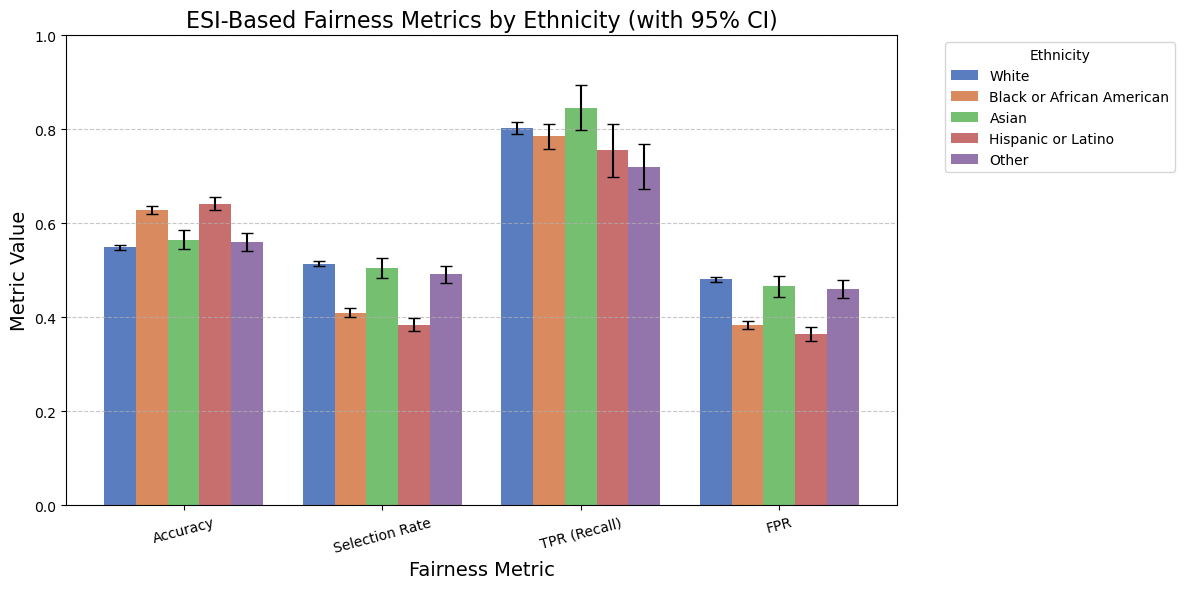

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_esi_ethnicity_plot = []

for row in ethnicity_metrics:
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_esi_ethnicity_plot.append({
            'Group': row['Ethnicity'],
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_ethnicity_plot = pd.DataFrame(df_esi_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_esi_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)

metric_list = df_esi_ethnicity_plot['Metric'].unique()
group_list = df_esi_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups 

for i, metric in enumerate(metric_list):
    subset = df_esi_ethnicity_plot[df_esi_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Ethnicity (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

threshold_value = np.percentile(df_test["ESI"], 70)  
y_pred_esi = (df_test["ESI"] >= threshold_value).astype(int)


age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels)

valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred_esi[valid_mask]  
age_grouped_clean = age_grouped[valid_mask]


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_age, y_pred_age)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)


print("\n=== ESI - Fairness Metrics by Age Group (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Fairness Metrics by Age Group (Mean + 95% CI) ===
Accuracy:              Mean = 0.652, CI = (0.649, 0.655)
Demographic Parity:    Mean = 0.294, CI = (0.282, 0.306)
Equal Opportunity:     Mean = 0.179, CI = (0.128, 0.239)
Equalized Odds:        Mean = 0.264, CI = (0.251, 0.277)


In [22]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np
import pandas as pd

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== ESI - Bootstrapped Metrics by Age Group (Mean and 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI - Bootstrapped Metrics by Age Group (Mean and 95% CI) ===

Age Group: 0–17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18–24
Accuracy          Mean = 0.758, CI = (0.749, 0.766)
Selection Rate    Mean = 0.248, CI = (0.240, 0.257)
TPR (Recall)      Mean = 0.650, CI = (0.580, 0.716)
FPR               Mean = 0.240, CI = (0.232, 0.249)

Age Group: 25–34
Accuracy          Mean = 0.735, CI = (0.728, 0.743)
Selection Rate    Mean = 0.273, CI = (0.266, 0.281)
TPR (Recall)      Mean = 0.662, CI = (0.611, 0.715)
FPR               Mean = 0.263, CI = (0.256, 0.271)

Age Group: 35–44
Accuracy          Mean = 0.712, CI = (0.703, 0.721)
Selection Rate    Mean = 0.305, CI = (0.296, 0.314)
TPR (Recall)      Mean = 0.734, CI = (0.687, 0.776)
FPR               Mean = 0.289, CI = (0.280, 0.298)

Age Group: 45–54
Accuracy          Mean = 0.670, CI = (0.662, 0.678)
Selection Rate    Mean =

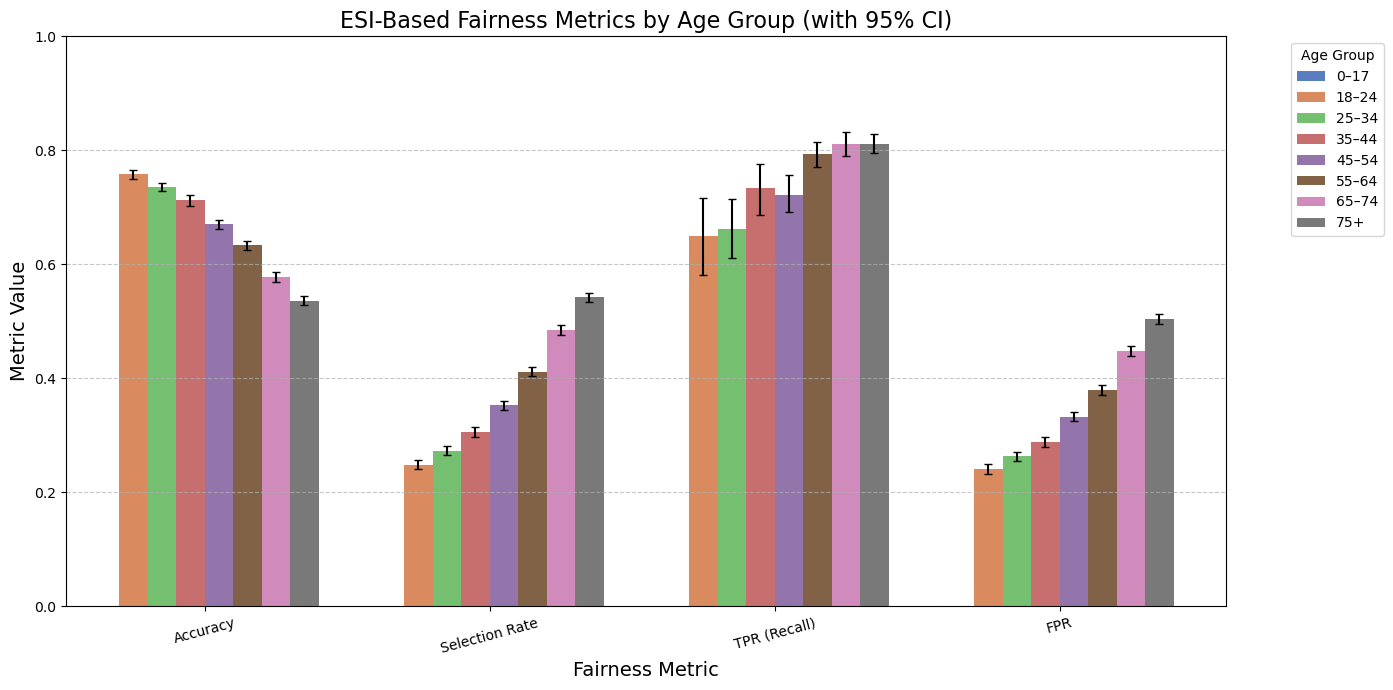

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df_esi_age_plot = []

for row in group_metrics:
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_esi_age_plot.append({
            'Group': row['Age Group'],
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_age_plot = pd.DataFrame(df_esi_age_plot)


plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_esi_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)


metric_list = df_esi_age_plot['Metric'].unique()
group_list = df_esi_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_esi_age_plot[df_esi_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=3
            )


plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Age Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [25]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


threshold_value = np.percentile(df_test["ESI"], 70) 
y_pred_esi = (df_test["ESI"] >= threshold_value).astype(int)


insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_esi[valid_mask]  

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)


print("\n=== ESI - Bootstrapped Fairness & Accuracy Metrics by Insurance ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Bootstrapped Fairness & Accuracy Metrics by Insurance ===
Accuracy:              Mean = 0.507, CI = (0.502, 0.512)
Demographic Parity:    Mean = 0.091, CI = (0.075, 0.109)
Equal Opportunity:     Mean = 0.075, CI = (0.033, 0.120)
Equalized Odds:        Mean = 0.089, CI = (0.069, 0.120)


In [26]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


insurance_metrics = []

for group in insurance_grouped.unique():
    mask = (insurance_grouped == group).values

    if mask.sum() == 0:
        insurance_metrics.append({
            'Insurance Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    insurance_metrics.append({
        'Insurance Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })


print("\n=== ESI - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===")
for row in insurance_metrics:
    print(f"\nInsurance Group: {row['Insurance Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===

Insurance Group: Medicaid
Accuracy          Mean = 0.536, CI = (0.520, 0.552)
Selection Rate    Mean = 0.519, CI = (0.504, 0.533)
TPR (Recall)      Mean = 0.727, CI = (0.690, 0.765)
FPR               Mean = 0.490, CI = (0.473, 0.507)

Insurance Group: Medicare
Accuracy          Mean = 0.487, CI = (0.479, 0.494)
Selection Rate    Mean = 0.610, CI = (0.603, 0.618)
TPR (Recall)      Mean = 0.800, CI = (0.784, 0.816)
FPR               Mean = 0.574, CI = (0.565, 0.582)

Insurance Group: Other
Accuracy          Mean = 0.517, CI = (0.511, 0.523)
Selection Rate    Mean = 0.550, CI = (0.543, 0.556)
TPR (Recall)      Mean = 0.767, CI = (0.752, 0.784)
FPR               Mean = 0.519, CI = (0.512, 0.526)


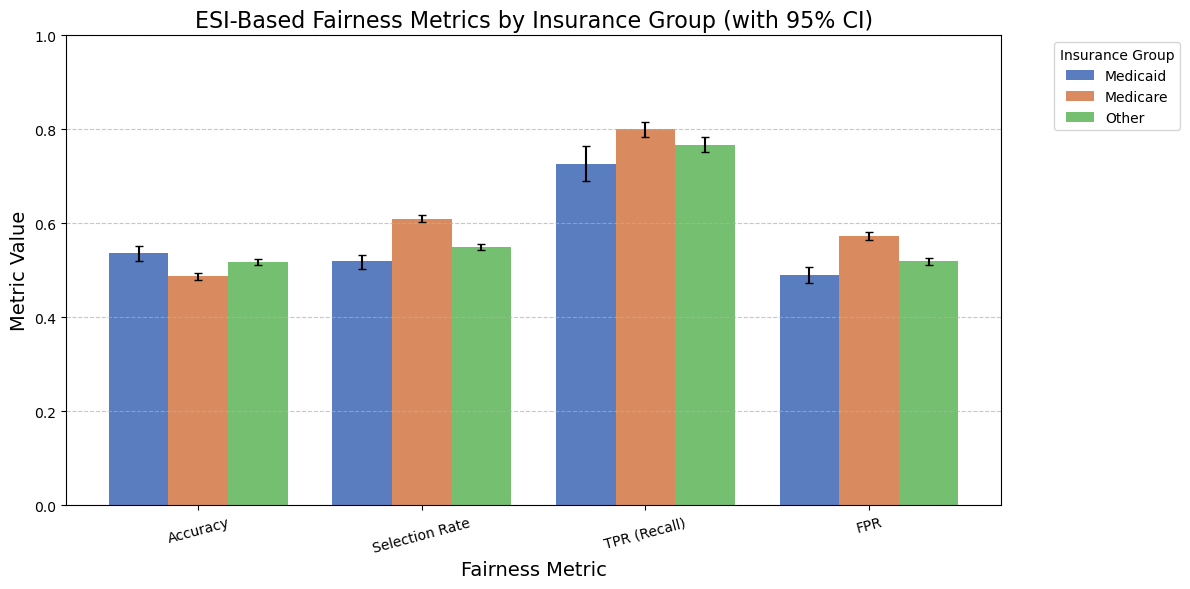

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_esi_insurance_plot = []

for row in insurance_metrics:
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_esi_insurance_plot.append({
            'Group': row['Insurance Group'],
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_insurance_plot = pd.DataFrame(df_esi_insurance_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_esi_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None, 
    capsize=0.2
)


metric_list = df_esi_insurance_plot['Metric'].unique()
group_list = df_esi_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_esi_insurance_plot[df_esi_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=3
            )

plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Insurance Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Crtical.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.8462702241626242
AUPRC: 0.27840073486535316
Sensitivity: 0.8047210300429185
Specificity: 0.7280455982972788
Score thresold: 66
2.5 97.5


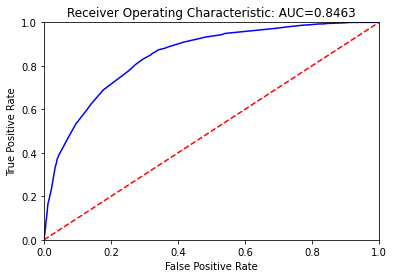

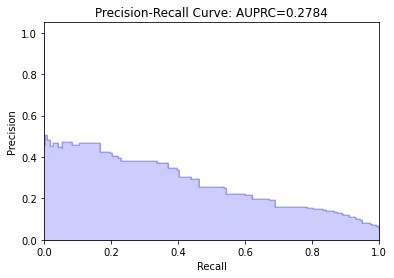

In [20]:
get_score_performance("AutoScore", random_seed=random_seed) 

score_NEWS
AUC: 0.6341903573953401
AUPRC: 0.14157240789712475
Sensitivity: 0.46390948107686303
Specificity: 0.7954810548213707
Score thresold: 2
2.5 97.5


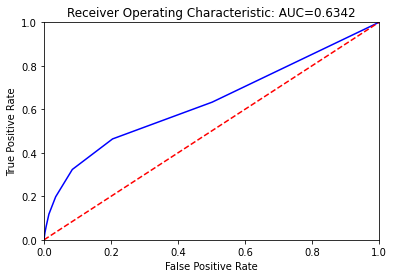

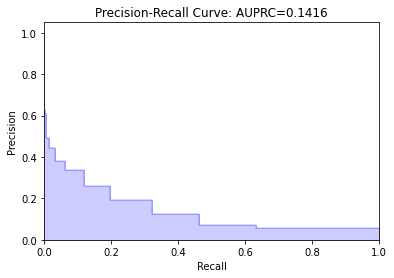

In [21]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6165137178284772
AUPRC: 0.12807667183072463
Sensitivity: 0.4104564962934062
Specificity: 0.8225490313969288
Score thresold: 2
2.5 97.5


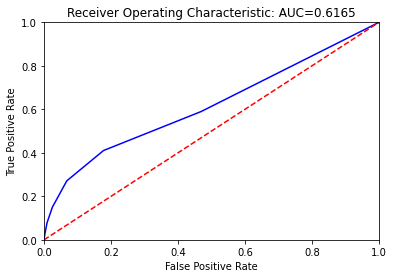

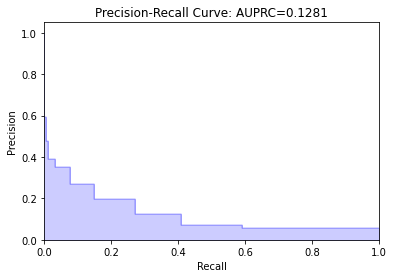

In [22]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6858237001110102
AUPRC: 0.10555264874976322
Sensitivity: 0.6808427623878268
Specificity: 0.6155649883960029
Score thresold: 5
2.5 97.5


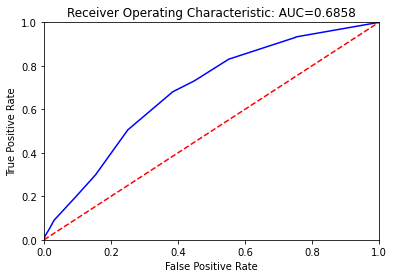

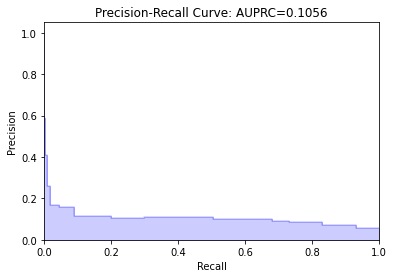

In [23]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6136127819001566
AUPRC: 0.10350411545674533
Sensitivity: 0.43055013655872026
Specificity: 0.7698801120717644
Score thresold: 2
2.5 97.5


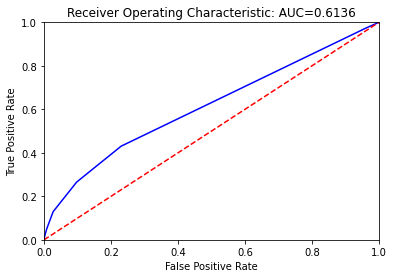

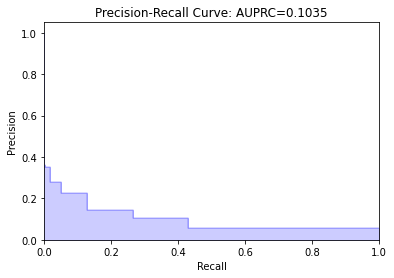

In [24]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7074561210922072
AUPRC: 0.14183887641580045
Sensitivity: 0.5901287553648069
Specificity: 0.7307271437332403
Score thresold: 6
2.5 97.5


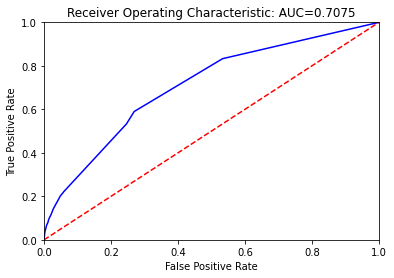

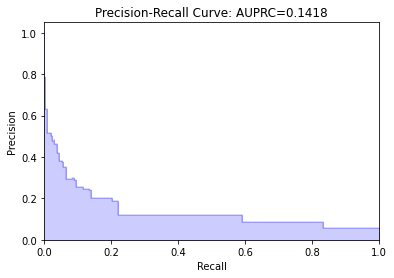

In [25]:
get_score_performance("score_CART", random_seed=random_seed)

In [17]:
!pip uninstall -y numpy
!pip install numpy==1.23.0


Found existing installation: numpy 1.22.4
Uninstalling numpy-1.22.4:
  Successfully uninstalled numpy-1.22.4
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.0.tar.gz (10.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.0-cp311-cp311-linux_x86_64.whl size=6149553 sha256=1aa39509bc182f03ec42c0c2461c2c0dbb56e9ce77db4b7d67b20adcad147357
  Stored in directory: /sfs/gpfs/tardis/home/rkc7gr/.cache/pip/wheels/6d/36/1a/3ec6b85008bea3151efb003f5d41baa7bf4966cb43c1c2470b
Successfully built numpy
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fairlearn 0.12.0 require

In [25]:
import importlib
import embedding  # your embedding.py file
importlib.reload(embedding)
from embedding import create_embedding_model

In [26]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [27]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


In [30]:
# # To train from scratch, set load_model to None
# load_model = None#"embedding_critical_"+version 
# save_model = "embedding_critical_"+version

# if load_model:
#         model = keras.models.load_model(load_model)
# else:
#         model = create_embedding_model(vocabulary, len(variable))
# model.summary()
# # model.compile(loss='binary_crossentropy', 
# #         optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
# #         metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
# #                     'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

# model.compile(
#     loss='binary_crossentropy',
#     optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01),
#     metrics=[
#         'accuracy',
#         metrics.AUC(name='auc'),  # regular AUC
#         metrics.AUC(name='aucpr', curve='PR'),  # precision-recall AUC
#         metrics.TruePositives(name='tp'),
#         metrics.TrueNegatives(name='tn'),
#         metrics.Precision(name='precision'),
#         metrics.Recall(name='recall')
#     ]
# )

# runtime = 1063.299 # to be updated
# if not load_model:
#         start = time.time()
#         model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
#         runtime = time.time()-start
#         print('Training time:', runtime, 'seconds')
# if save_model:
#         keras.models.save_model(model, save_model)
# output = model.predict(test_gen)
# result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

# results = ["Med2Vec"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

### 4. Performance output

In [29]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

Model  Threshold                AUROC                AUPRC  \
0            LR      0.065  0.864 (0.859-0.868)  0.321 (0.308-0.336)   
1            RF      0.078   0.875 (0.87-0.879)    0.38 (0.37-0.393)   
2            GB      0.064   0.88 (0.876-0.884)  0.387 (0.373-0.405)   
3           MLP      0.046  0.883 (0.879-0.888)  0.389 (0.377-0.407)   
4           ESI     -2.000  0.804 (0.801-0.809)  0.194 (0.187-0.205)   
5     AutoScore     66.000  0.846 (0.842-0.851)  0.278 (0.267-0.293)   
6    score_NEWS      2.000  0.634 (0.627-0.641)  0.142 (0.132-0.145)   
7   score_NEWS2      2.000  0.617 (0.608-0.624)  0.128 (0.122-0.132)   
8    score_REMS      5.000  0.686 (0.679-0.691)  0.106 (0.102-0.111)   
9    score_MEWS      2.000  0.614 (0.607-0.618)    0.104 (0.1-0.109)   
10   score_CART      6.000  0.707 (0.702-0.714)  0.142 (0.132-0.149)   
11      Med2Vec      0.004  0.848 (0.845-0.851)   0.301 (0.29-0.314)   

            Sensitivity          Specificity   Runtime  
0   0.783 (0.773-0.809)  0.785 (0.756-0.793)     3.867  
1    0.803 (0.794-0.81)  0.792 (0.791-0.795)    51.004  
2    0.809 (0.79-0.821)    0.79 (0.783-0.81)    58.408  
3   0.813 (0.805-0.829)  0.787 (0.772-0.794)   171.311  
4    0.87 (0.863-0.875)   0.64 (0.637-0.643)     0.000  
5    0.805 (0.785-0.81)  0.728 (0.726-0.747)     0.000  
6   0.464 (0.453-0.472)  0.795 (0.793-0.798)     0.000  
7    0.41 (0.398-0.585)  0.823 (0.532-0.824)     0.000  
8   0.681 (0.668-0.687)  0.616 (0.613-0.619)     0.000  
9   0.431 (0.418-0.439)   0.77 (0.768-0.772)     0.000  
10   0.59 (0.578-0.599)  0.731 (0.728-0.733)     0.000  
11  0.783 (0.768-0.798)  0.767 (0.756-0.788)  1052.930

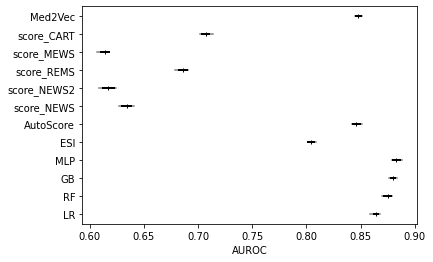

In [30]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

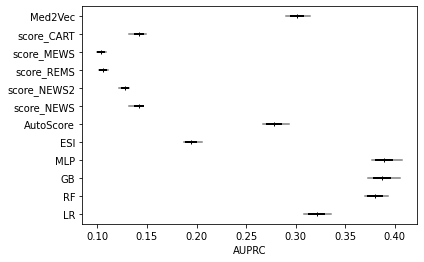

In [31]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [32]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

Variable  Importance
0                            age    0.099796
15                    triage_sbp    0.099777
12              triage_heartrate    0.093150
18                 triage_acuity    0.092089
16                    triage_dbp    0.083790
11            triage_temperature    0.076566
13               triage_resprate    0.056675
14                  triage_o2sat    0.050482
17                   triage_pain    0.039823
4                      n_ed_365d    0.018656
7                    n_hosp_365d    0.016997
1                         gender    0.014985
10                    n_icu_365d    0.012168
3                       n_ed_90d    0.010174
6                     n_hosp_90d    0.010114
50                      eci_HTN2    0.009058
38                       cci_DM1    0.007454
34                 cci_Pulmonary    0.007398
46                eci_Arrhythmia    0.007139
63                eci_Depression    0.006895
57               eci_FluidsLytes    0.006862
9                      n_icu_90d    0.006536
2                       n_ed_30d    0.006438
5                     n_hosp_30d    0.006387
20       chiefcom_abdominal_pain    0.006334
51                eci_NeuroOther    0.005972
19           chiefcom_chest_pain    0.005797
30                       cci_CHF    0.005694
52               eci_Hypothyroid    0.005657
55                   eci_Obesity    0.005610
54              eci_Coagulopathy    0.005574
42                   cci_Cancer1    0.005401
29                        cci_MI    0.005085
32                    cci_Stroke    0.005083
31                       cci_PVD    0.005064
41                     cci_Renal    0.005037
49                      eci_HTN1    0.004940
26         chiefcom_fever_chills    0.004839
56                eci_WeightLoss    0.004777
47                  eci_Valvular    0.004754
60                   eci_Alcohol    0.004745
39                       cci_DM2    0.004732
37                    cci_Liver1    0.004704
59                    eci_Anemia    0.004509
48                      eci_PHTN    0.004503
21             chiefcom_headache    0.003941
61                     eci_Drugs    0.003743
44                   cci_Cancer2    0.003740
27              chiefcom_syncope    0.003449
8                      n_icu_30d    0.003146
28            chiefcom_dizziness    0.003011
43                    cci_Liver2    0.002926
33                  cci_Dementia    0.002906
25      chiefcom_nausea_vomiting    0.002857
36                       cci_PUD    0.002747
35                 cci_Rheumatic    0.002678
62                 eci_Psychoses    0.002651
40                 cci_Paralysis    0.002611
24                chiefcom_cough    0.002448
58                 eci_BloodLoss    0.002299
23            chiefcom_back_pain    0.002160
53                  eci_Lymphoma    0.001826
22  chiefcom_shortness_of_breath    0.001445
45                       cci_HIV    0.001199